In [1]:
import numpy as np
import torch
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

%matplotlib inline

# PDMP

## Setup

In [3]:
import numpy as np
import torch
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True, # shit
    'dropout_rate' : .1,
    'nblocks' : 2,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, # must be even. I'd say must be superior to diffusion steps other wise bad performance
    #'nfeatures' : n_features,
    'compute_gamma': False,
    #'exp_block': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'sas_grid',
    'std' : 0.01, # 0.5, 0.05,
    'n_mixture' : 9, # must be square. set to None if not a grid mixture
    'normalized' : True,
    #'weights': np.array([1/2]*2),
    'weights': [.01, .1, .3, 
                .2, .02, .15,
                .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'data_alpha': 1.8,
    'isotropic': True
}

device = 'mps'

* model takes $(X_t, V_t)$ as input (4d). Must output $\lambda_i$ for each i (there are 2 in 2d)
* since we don;t have an explicit expression for $p_t$ we must simulate a whole run for each batch. So we have a list of timesteps per datapoints
* Moreover, pdmp.T is the time horizon, but the number of steps per datapoint is random. It depends on the number of jumps. skeletons stores the number of jumps.
* Either condition on component $i$, or just output all the $\lambda_i$. Maybe it is better the condition, because the component may behave wildy differently.

In [4]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pdmp as pdmp
import Data as Data
import Generate as Gen
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt

# original data, get dataloader
gmm_2 = Data.Generator('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate(n_samples = 1e4)
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset((GMM2), torch.tensor([0.]).repeat(GMM2.shape[0]))
data = DataLoader(dataset, 
                    batch_size=8000, 
                    shuffle=True, 
                    num_workers=1)

# model
model = LevyDiffusionModel({'data': p_data_2d, 'model':p_model_2d, 'device': 'cpu'}).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-2, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = pdmp.PDMP(total_time = 30)

# for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

## Look at the noised data

In [3]:
data_clone = GMM2.clone()

In [4]:
data_clone.shape

torch.Size([10000, 1, 2])

In [4]:
time_horizons = torch.ones(data_clone.shape) * 30. #pdmp.T

In [5]:
#data_clone = data_clone.clone()
pdmp.forward(data_clone, time_horizons) # [pdmp.forward(GMM2[i].clone(), torch.ones(GMM2[i].shape) * pdmp.T) for i in range(1000)]

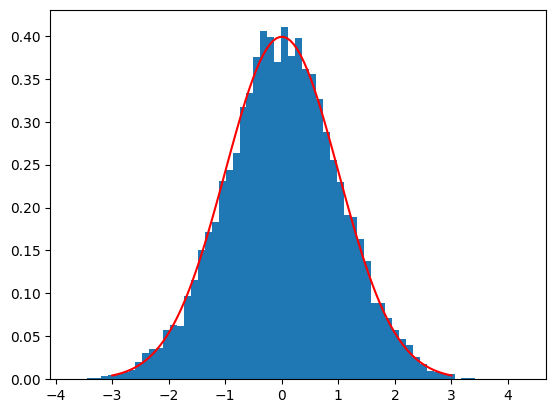

In [6]:
# look at histogram of one component at different timesteps
# T = [s.time for s in skeleton]
pos = data_clone.squeeze(1)#[[s[t].position[0] for s in skeletons] for t in [10, 20, 30, 40, -1]]
import scipy.stats as stats
import numpy as np
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

In [6]:
def get_position_time_t(skeleton, t):
    prev_s = skeleton[0]
    for s in skeleton:
        if s.time < t:
            prev_s = s
            continue
        else:
            return prev_s.position + prev_s.velocity * (t - prev_s.time)


In [7]:
positions = torch.tensor(np.stack([np.stack([get_position_time_t(s, t) for s in skeletons ]) for t in np.linspace(0, 30, 60*10)]))
positions = positions.unsqueeze(-2)# add channel

'./animation/undefined_distribution.mp4'

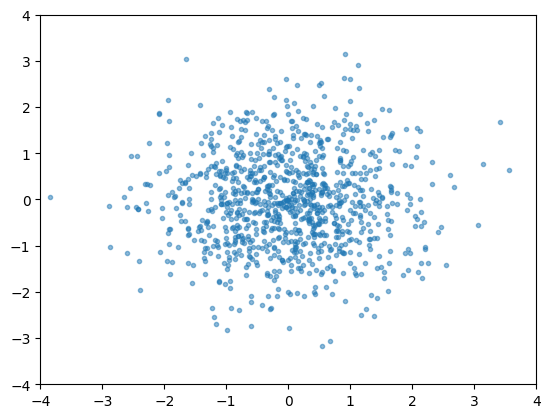

In [9]:
gen_model.history = positions
gen_model.animation(plot_original_data = False, limit_nb_orig_data = 1000, 
                   xlim = (-4, 4), ylim = (-4, 4))

## Train the model

In [2]:
# load
chpt = torch.load('models/first_model.pt')
model.load_state_dict(chpt['model'])
optimizer.load_state_dict(chpt['optimizer'])

NameError: name 'model' is not defined

In [5]:
from tqdm import tqdm
import torch.nn as nn

grad_clip = None

def get_position_speed_time_t(skeleton, t):
    prev_s = skeleton[0]
    for s in skeleton:
        if s.time < t:
            prev_s = s
            continue
        else:
            pos = torch.tensor(prev_s.position + prev_s.velocity * (t - prev_s.time))
            speed = torch.tensor(prev_s.velocity)
            return torch.concat((pos, speed))

# training
model.train()
for i in tqdm(range(20)):
    epoch_loss = steps = 0
    for i, (Xbatch, y) in enumerate(data):
        # training loss
        Vbatch = torch.tensor([-1., 1.])[torch.randint(0, 2, (2*Xbatch.shape[0],))]
        Vbatch = Vbatch.reshape(Xbatch.shape[0], 1, 2)
        # skeletons = [pdmp.forward(x[0], pdmp.T, v[0]) for x, v in zip(Xbatch, Vbatch)]
        #t = torch.tensor([skeleton[torch.randint(0, len(skeleton), (1,))].time for skeleton in skeletons])
        time_horizons = pdmp.T * torch.rand(Xbatch.shape[0])
        t = time_horizons.clone().detach().unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 2)
        
        x = Xbatch.clone()
        v = Vbatch.clone()
        
        pdmp.forward(Xbatch, t, Vbatch)
        
        assert ((x != Xbatch).any()) and ((v != Vbatch).any())
        #print(t)
        assert not (t != 0.).any()
        
        #x_v_t = torch.stack([get_position_speed_time_t(s_i, t_i.item()) for s_i, t_i in zip(skeletons, t)])
        #x_v_t = x_v_t.unsqueeze(1).to(device) # add channel
        Xbatch = Xbatch.to(device)
        Vbatch = Vbatch.to(device)
        time_horizons = time_horizons.to(device)
        #print(time_horizons)
        
        # tensor to give as input to the model
        X_V_t = torch.concat((Xbatch, Vbatch), dim = -1)
        output = model(X_V_t, time_horizons)
        
        # invert time, choose random
        X_V_inv_t_1 = X_V_t.detach().clone()
        X_V_inv_t_2 = X_V_t.detach().clone()
        #pos_inv = torch.tensor([0., 1.])[torch.randint(0, 2, (Xbatch.shape[0],))]
        X_V_inv_t_1[:, :, 2] *= -1 # reverse speed
        X_V_inv_t_2[:, :, 3] *= -1 # reverse speed
        output_inv_1 = model(X_V_inv_t_1, time_horizons)
        output_inv_2 = model(X_V_inv_t_2, time_horizons)
        
        loss = 0.5*output[:, :, 0]**2 - (output_inv_1[:,:,0])
        loss += 0.5*output[:, :, 1]**2 - (output_inv_2[:,:,1])
        #print(loss)
        #print(output)
        #print(output_inv_1)
        #print(output_inv_2)
        #loss += (output - 1 / (output_inv + 1e-6))**2
        loss = loss.mean()
        # and finally gradient descent
        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        #learning_schedule.step()
        epoch_loss += loss.item()
        #print(loss.item())
        #print(output[0])
        steps+= 1
    epoch_loss = epoch_loss / steps
    print('epoch_loss :{}'.format(epoch_loss))

  0%|                                                    | 0/20 [00:00<?, ?it/s]

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])


  5%|██▏                                         | 1/20 [00:01<00:37,  1.98s/it]

epoch_loss :-0.20437226817011833
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])


 10%|████▍                                       | 2/20 [00:03<00:33,  1.86s/it]

epoch_loss :-0.359310582280159


 15%|██████▌                                     | 3/20 [00:05<00:28,  1.68s/it]

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
epoch_loss :-0.6874908804893494


 20%|████████▊                                   | 4/20 [00:06<00:26,  1.68s/it]

tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        ...,

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])
epoch_loss :-0.7533246278762817


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
 20%|████████▊                                   | 4/20 [00:07<00:31,  1.95s/it]    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main


Unexpected exception formatting exception. Falling back to standard exception



    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/__init__.py", line 1531, in <module>
    import torch.utils.data
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/__init__.py", line 21, in <module>
    from torch.utils.data.datapipes.datapipe import (
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/datapipes/__init__.py", line 1, in <module>
    from . import iter
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/__init__.py", line 1, in <module>
    from torch.utils.data.datapipes.iter.utils import (
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/utils.py", line 3, in <module>
    from torch.utils.data.datapipes.datapipe import IterDataPipe
  File "/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/utils/data/datapipes/dat

In [4]:
# save model
checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, 'models/model_unstable.pt')

In [88]:
import numpy as np
np.dot(np.eye(2),np.array([0, 1]))

array([0., 1.])

In [53]:
# generate data
## For the backward process
def flip_given_rate(v, lambdas, s):
    lambdas[lambdas == 0.] += 1e-9
    event_time = torch.distributions.exponential.Exponential(lambdas)
    v[event_time.sample() <= s] *= -1.

def splitting_zzs_DBD(model, δ, N, nsamples = None, x_init=None, v_init=None):
    assert (nsamples is not None) or (x_init is not None) or (v_init is not None) 
    if x_init is None:
        x_init = torch.randn(nsamples, 1, 2)
    if v_init is None:
        v_init = torch.tensor([-1., 1.])[torch.randint(0, 2, (x_init.shape[0],))].reshape(x_init.shape[0], 1, 1).repeat(1, *(x_init.shape[1:]))
    #chain = [pdmp.Skeleton(torch.clone(x_init), torch.clone(v_init), 0.)]
    chain = []
    x = x_init.clone()
    v = v_init.clone()
    model.eval()
    #print(x)
    with torch.inference_mode():
        for n in range(int(N), 1, -1):
            chain.append(torch.concat((x, v), dim = -1))
            # compute x_n-1 from x_n
            x = x - v * δ / 2
            time = float(n * δ - δ / 2) #float(n - δ / 2)
            density_ratio = model(torch.concat((x,v), dim = -1).to(device),
                                  (torch.ones(x.shape[0])*time).to(device))
            print(density_ratio)
            #print(grad_x)
            switch_rate = density_ratio.cpu()* torch.maximum(torch.zeros(x.shape), -v * x)
            #print(switch_rate)
            #print(switch_rate[switch_rate <= 0.])
            flip_given_rate(v, switch_rate, δ)
            x = x - v * δ / 2
            #print(x, v)
            #chain.append(Skeleton(x.copy(), v.copy(), n * δ))
    chain.append(torch.concat((x, v), dim = -1))
    return chain


In [55]:
delta = 1e-1
chain = torch.stack(splitting_zzs_DBD(model, delta, pdmp.T / delta, nsamples = 1))

tensor([[[0.9809, 0.9835]]], device='mps:0')
tensor([[[0.9815, 0.9862]]], device='mps:0')
tensor([[[0.9820, 0.9889]]], device='mps:0')
tensor([[[0.9824, 0.9917]]], device='mps:0')
tensor([[[0.9827, 0.9945]]], device='mps:0')
tensor([[[0.9830, 0.9972]]], device='mps:0')
tensor([[[0.9832, 0.9998]]], device='mps:0')
tensor([[[1.0039, 1.0462]]], device='mps:0')
tensor([[[1.0032, 1.0455]]], device='mps:0')
tensor([[[1.0024, 1.0445]]], device='mps:0')
tensor([[[1.0016, 1.0432]]], device='mps:0')
tensor([[[1.0009, 1.0417]]], device='mps:0')
tensor([[[0.9871, 1.0188]]], device='mps:0')
tensor([[[0.9874, 1.0172]]], device='mps:0')
tensor([[[0.9877, 1.0156]]], device='mps:0')
tensor([[[0.9878, 1.0141]]], device='mps:0')
tensor([[[0.9879, 1.0127]]], device='mps:0')
tensor([[[0.9878, 1.0114]]], device='mps:0')
tensor([[[0.9875, 1.0103]]], device='mps:0')
tensor([[[0.9871, 1.0095]]], device='mps:0')
tensor([[[0.9866, 1.0091]]], device='mps:0')
tensor([[[0.9858, 1.0092]]], device='mps:0')
tensor([[[

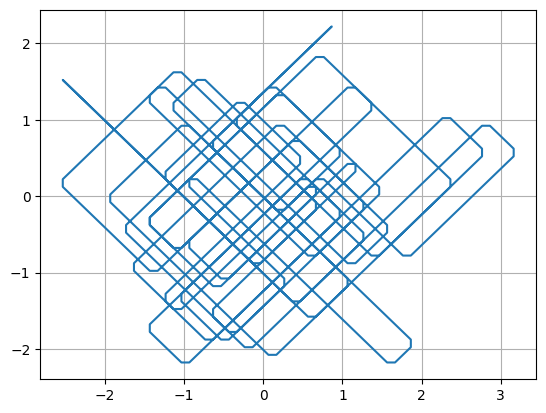

In [52]:
pos = chain[:, 3, :, :2].squeeze(-2)
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

In [42]:
gen_model.history = chain[:, :, :, :2]

In [ ]:
gen_model.animation(generated_data_name = 'check')

In [36]:
gen_model.samples = chain[-1][:, :, :2]

In [20]:
tmp = np.arange(10)
tmp[tmp < 5] = 2*tmp[tmp < 5]
tmp

array([0, 2, 4, 6, 8, 5, 6, 7, 8, 9])

In [ ]:
tmp = torch.arange(16*5).reshape(16, 1, 5)
tmp_2 = tmp[:, :, -1].flatten()
print(tmp_2)
tmp[tmp_2 < 15] = (tmp[tmp_2 < 15])**2
tmp

* model after 8 epochs

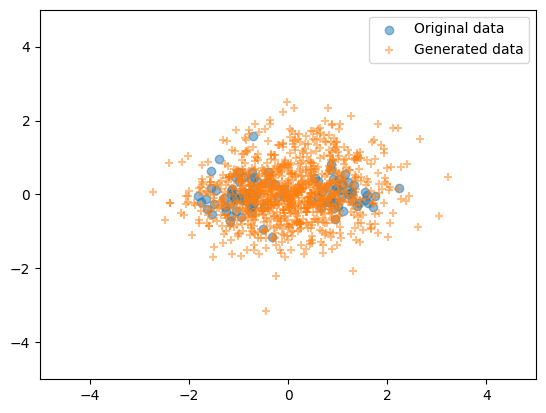

In [37]:
lims = 5
gen_model.get_plot(limit_nb_orig_data = 100, xlim = (-lims, lims), ylim = (-lims, lims))

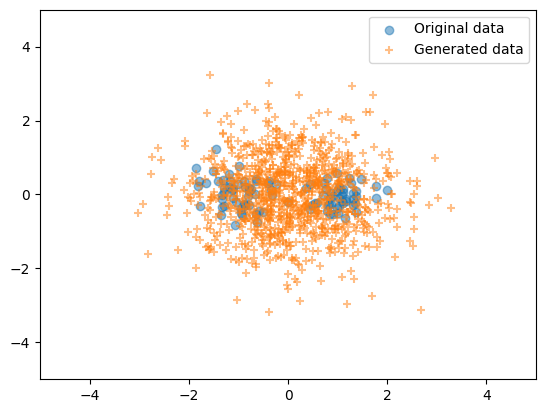

In [82]:
lims = 5
gen_model.get_plot(limit_nb_orig_data = 100, xlim = (-lims, lims), ylim = (-lims, lims))

In [61]:
gen_model.history = chain

'./animation/generation_1.mp4'

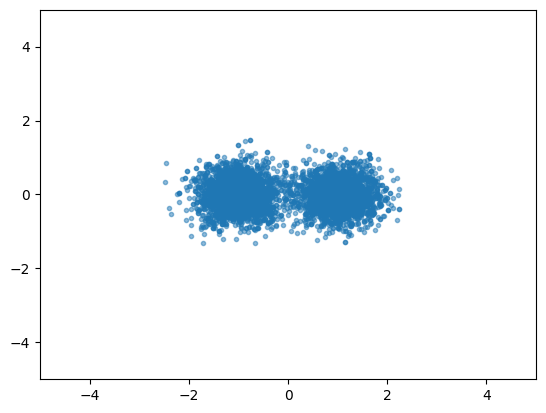

In [62]:
lims = 5
gen_model.animation(generated_data_name = 'generation_1',
                   xlim = (-lims, lims), ylim = (-lims, lims))

* after one iteration of the model

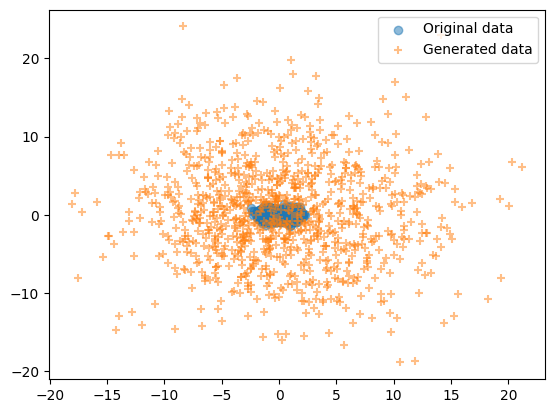

In [26]:
gen_model.get_plot(limit_nb_orig_data = 1000)

# MNIST

In [4]:

NUM_CLASSES = 10

def model_and_diffusion_defaults():
    """
    Defaults for image training.
    """
    return dict(
        image_size=64,
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        attention_resolutions="16,8",
        dropout=0.0,
        learn_sigma=False,
        sigma_small=False,
        class_cond=False,
        diffusion_steps=1000,
        noise_schedule="linear",
        timestep_respacing="",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=True,
        rescale_learned_sigmas=True,
        use_checkpoint=False,
        use_scale_shift_norm=True,
    )

def create_model(in_channels=3,
    image_size = 64,
    num_channels = 128,
    num_res_blocks = 2,
    learn_sigma = False,
    class_cond = False,
    use_checkpoint = False,
    attention_resolutions = '16, 8',
    num_heads = 4,
    num_heads_upsample=-1,
    use_scale_shift_norm = True,
    dropout = 0.0,
    alpha = 2.0,
    device = None,
    diffusion_steps = 1000
):
    if image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    elif image_size == 32:
        channel_mult = (1, 2, 2, 2)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    for res in attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))
    return unet.UNetModel(
        in_channels=in_channels,
        model_channels=num_channels,
        out_channels= in_channels if not learn_sigma else 2*in_channels,# (3 if not learn_sigma else 6),
        num_res_blocks=num_res_blocks,
        attention_resolutions=tuple(attention_ds),
        dropout=dropout,
        channel_mult=channel_mult,
        num_classes=(NUM_CLASSES if class_cond else None),
        use_checkpoint=use_checkpoint,
        num_heads=num_heads,
        num_heads_upsample=num_heads_upsample,
        use_scale_shift_norm=use_scale_shift_norm,
        alpha = alpha,
        diffusion_steps=diffusion_steps,
        device = device
    )


defaults = dict(
        data_dir="",
        schedule_sampler="uniform",
        lr=1e-3,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=1,
        microbatch=-1,  # -1 disables microbatches
        ema_rate="0.99",  # comma-separated list of EMA values
        log_interval=10,
        save_interval=10000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
    )

In [161]:
def my_unet_model():
    learn_gamma = False
    model = unet.UNetModel(
            in_channels=1,
            model_channels=32,
            out_channels= 1 if not learn_gamma else 2*1,# (3 if not learn_sigma else 6),
            num_res_blocks=2,
            attention_resolutions=tuple([2, 4]), # adds attention at image_size / 2 and /4
            dropout=.1,
            channel_mult=tuple([1]), #(1, 2, 2, 2), # divides image_size by two at each new item, except first one. [i] * model_channels
            dims = 1,
            num_classes= None,#(NUM_CLASSES if class_cond else None),
            use_checkpoint=False,
            num_heads=2,
            num_heads_upsample=-1, # same as num_heads
            use_scale_shift_norm=True,
            alpha = 1.8,
            diffusion_steps=60,
            device = device
        )
    return model
model = my_unet_model()

True
False
True
True
True
True


In [164]:
tmp_data = torch.tensor([[[1.]]]).repeat(8192, 1, 2)
model.eval()
with torch.inference_mode():
    res = model(tmp_data, torch.tensor([3.]))

starting forward
embedding ok
beginngin ok
input ok
middle ok
output ok


In [165]:
tmp_data.shape

torch.Size([8192, 1, 2])

In [29]:
import torchvision

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                                 #torchvision.transforms.Lambda(lambda x: nn.functional.pad(x, (2, 2, 2, 2), value=x[0][0][0][0]))
                             ])),
  batch_size=16, shuffle=True, num_workers=6)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=16, shuffle=True, num_workers=6)

In [40]:
from LevyDiffusion.Distributions import repeat_shape
tmp_1 = torch.tensor([[[[1.]]]]).repeat(16, 1, 32, 32)
tmp_2 = torch.tensor([2.]).repeat(16)
(tmp_1 * repeat_shape(tmp_2, tmp_1.size())).size()

torch.Size([16, 1, 32, 32])

In [30]:
import torch.nn as nn
_, (batch, cond) = next(enumerate(train_loader))
batch = nn.functional.pad(batch, (2, 2, 2, 2), value=batch[0][0][0][0]).to(device)

In [84]:
importlib.reload(Train)
importlib.reload(Algo)
logger = None #Logger.NeptuneLogger()
model = create_model(in_channels = 1, 
                     image_size = 32, 
                     device = device,  
                     num_channels=128,
                    alpha = 2.0)
model = model.to(device)
#manager = Manager.Manager(model, train_loader, logger)
#manager.train(epochs=1)

In [89]:
checkpoint = torch.load('models/unet/mnist_1.8_1.pt', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_parameters'])

<All keys matched successfully>

In [ ]:
model(batch, torch.tensor([1]).repeat(16).to(device))

In [90]:
importlib.reload(Gen)
importlib.reload(Algo)

gen_model = Gen.GenerationManager(model=model, device = device, original_data = batch.to(device))

In [91]:
gen_model.generate(32)

[32, 1, 32, 32]


100%|███████████████████████████████████████| 1000/1000 [02:20<00:00,  7.12it/s]


# Junk

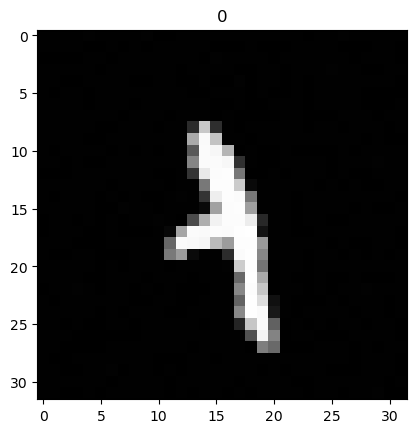

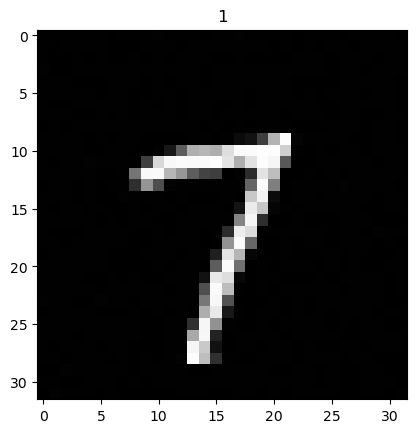

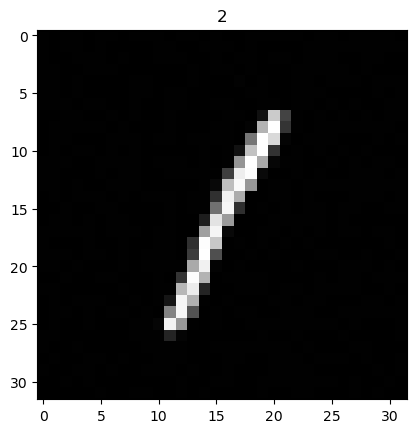

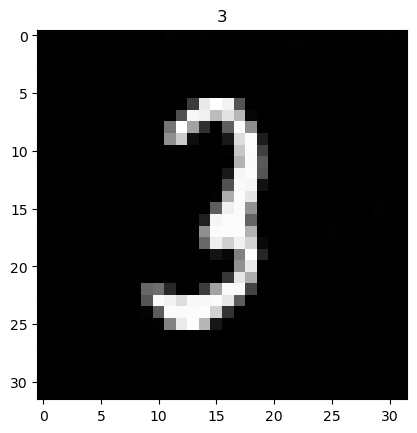

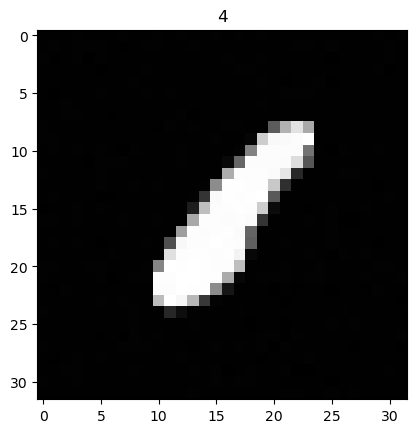

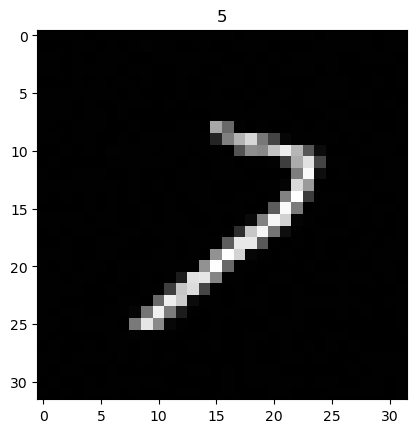

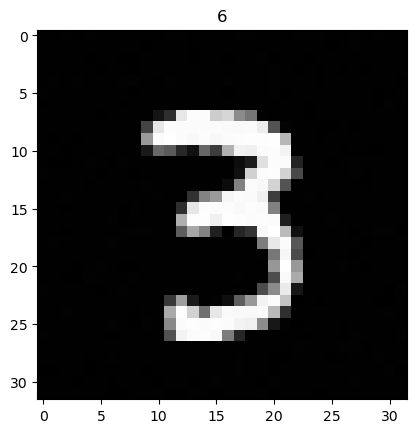

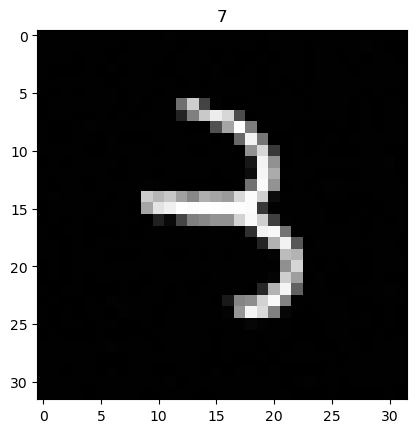

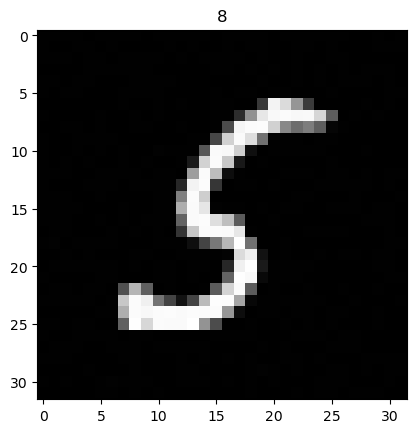

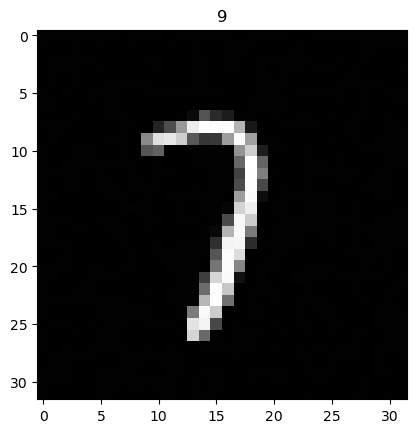

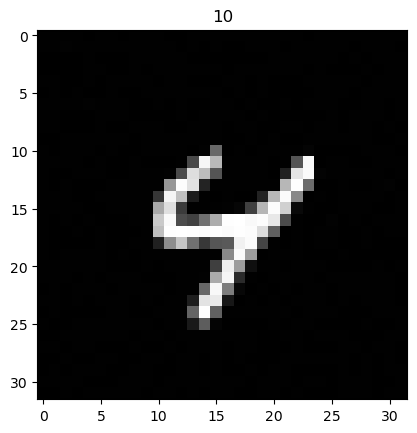

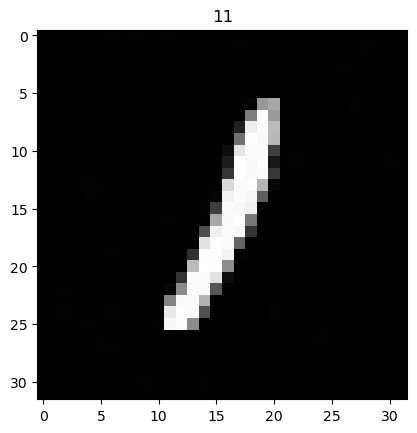

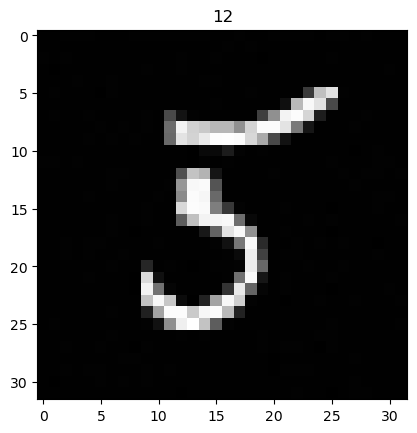

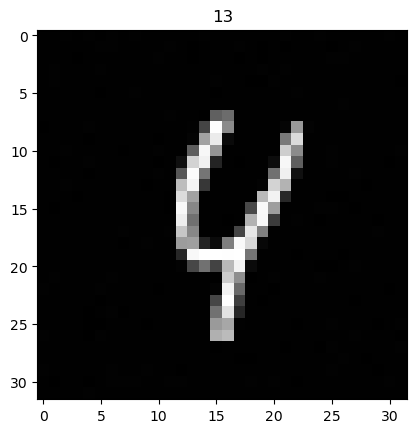

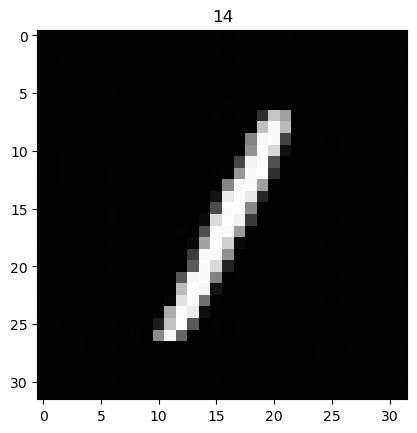

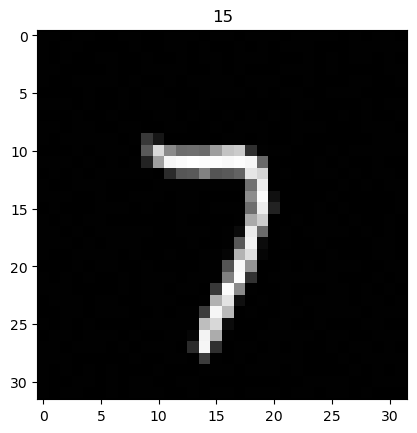

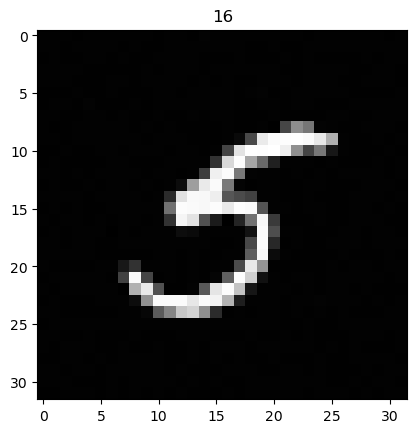

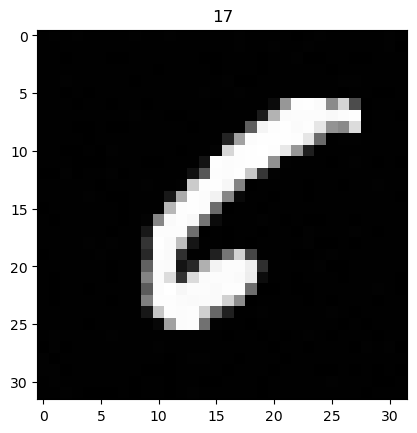

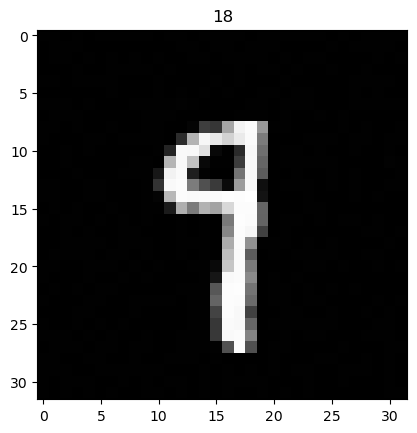

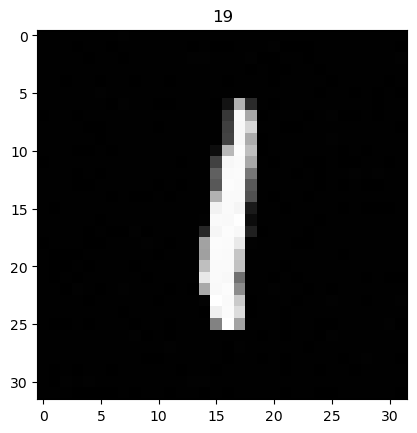

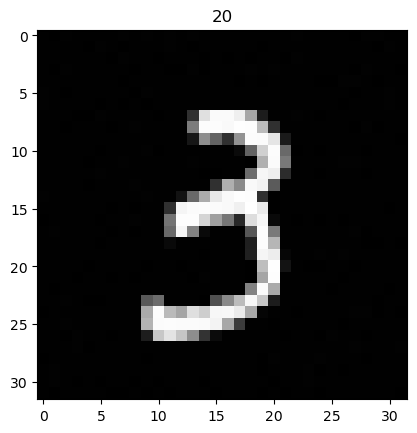

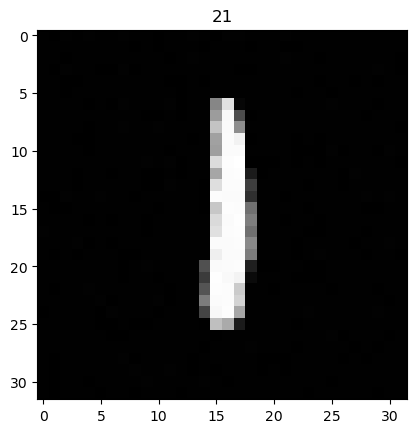

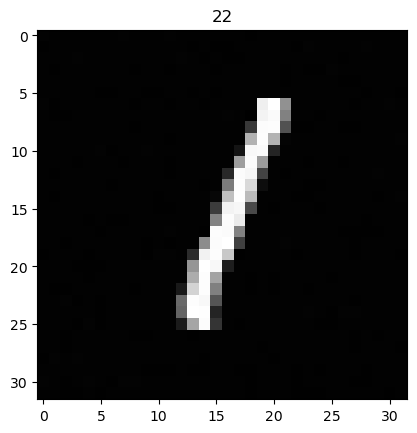

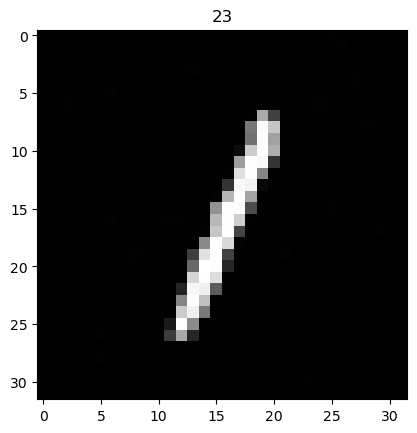

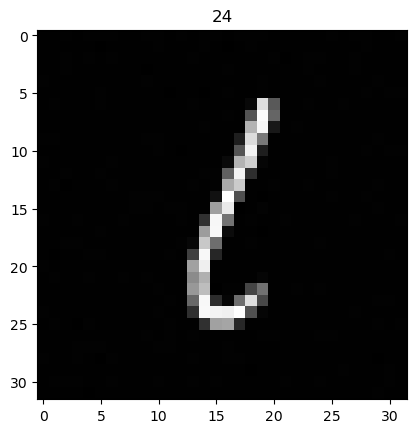

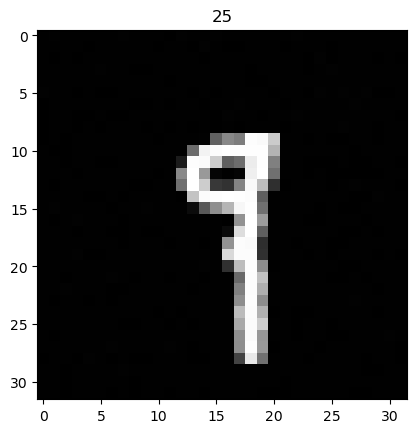

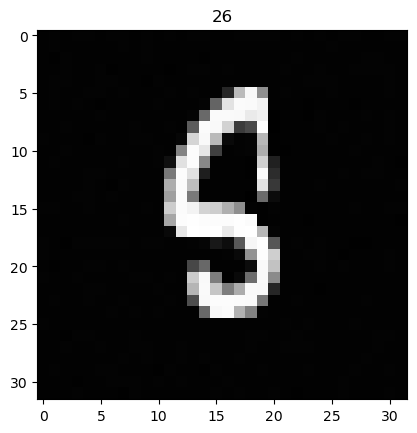

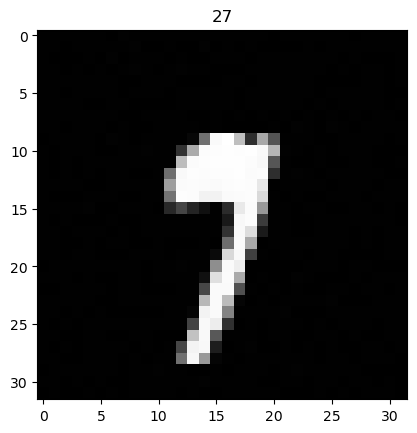

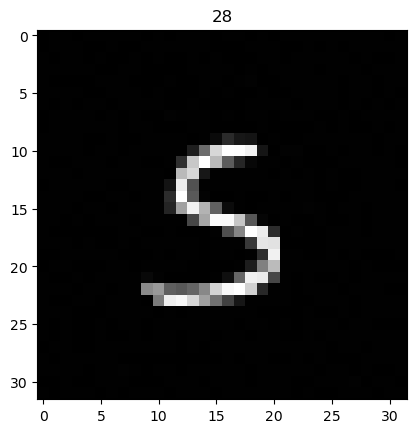

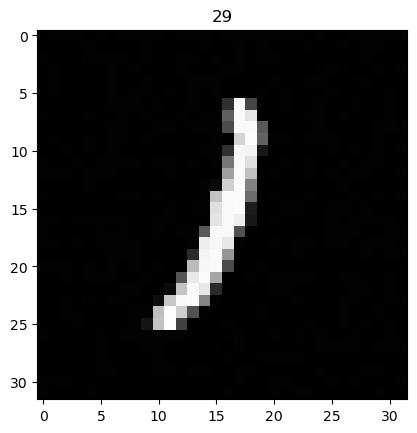

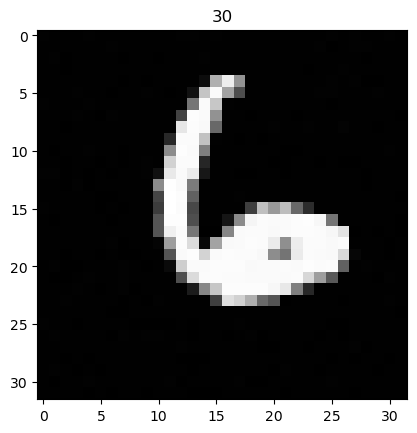

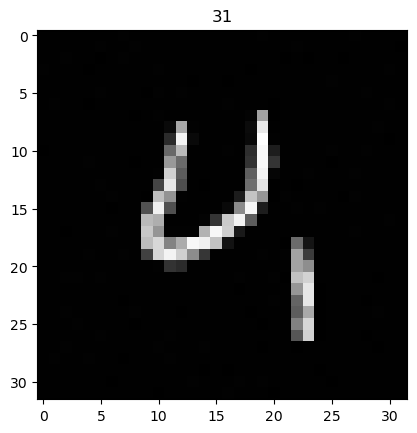

In [92]:
for i in range(gen_model.samples.size()[0]):
    plt.imshow(gen_model.samples[i][0], cmap='gray')
    plt.title('{}'.format(i))
    plt.show()

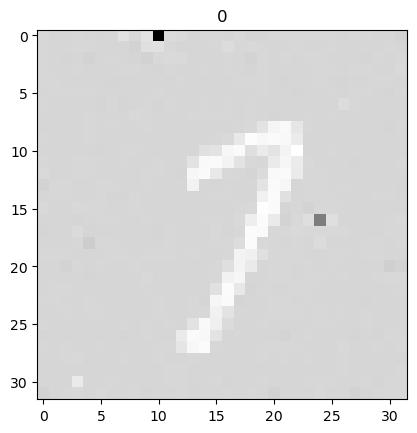

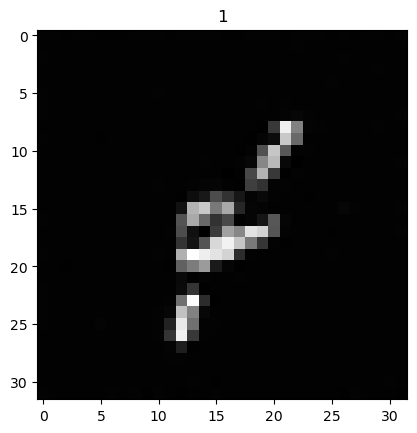

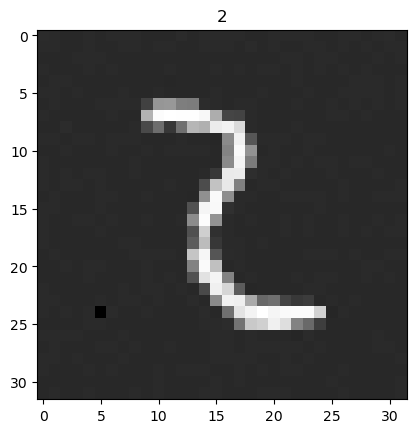

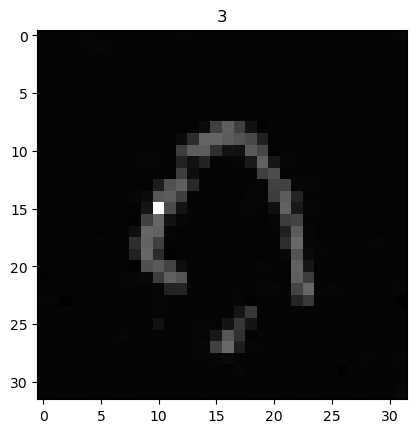

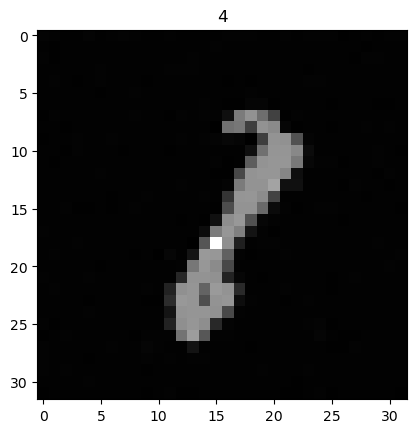

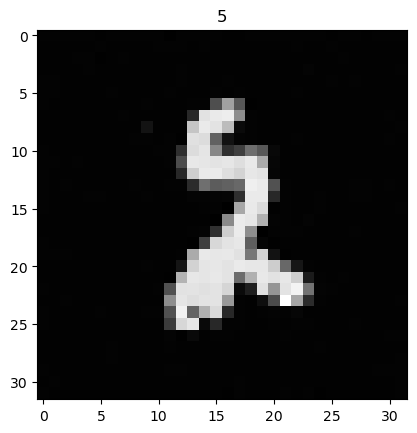

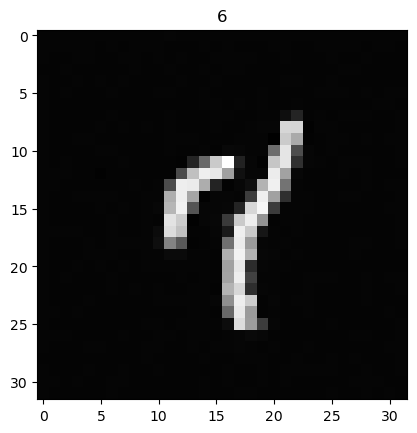

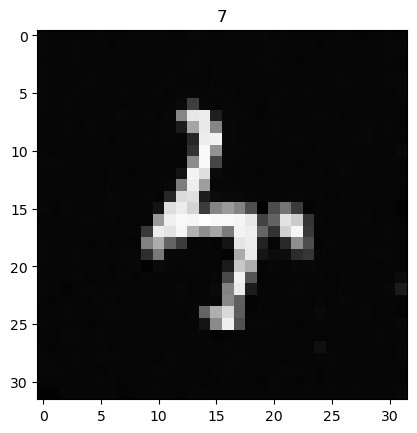

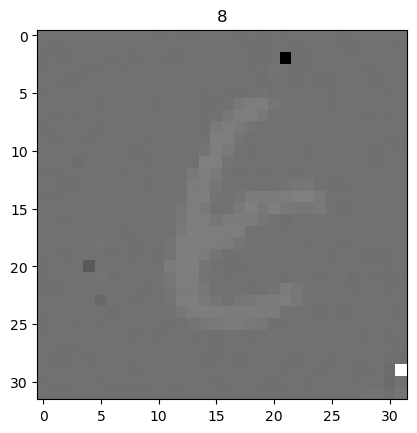

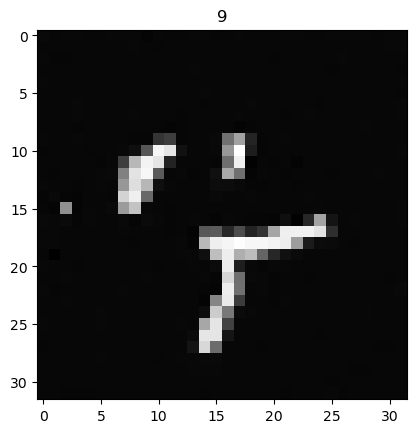

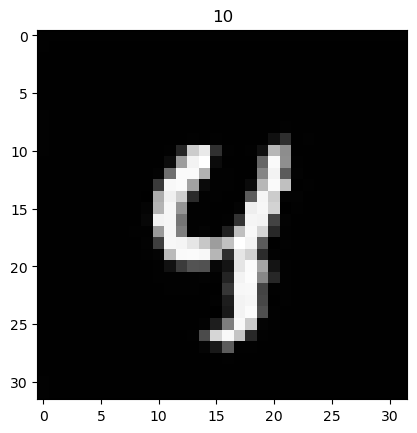

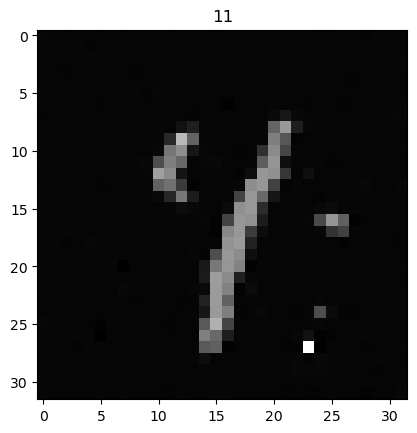

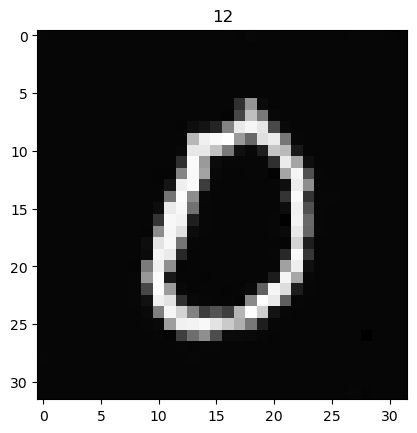

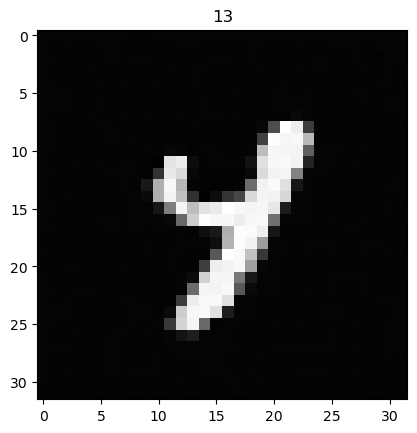

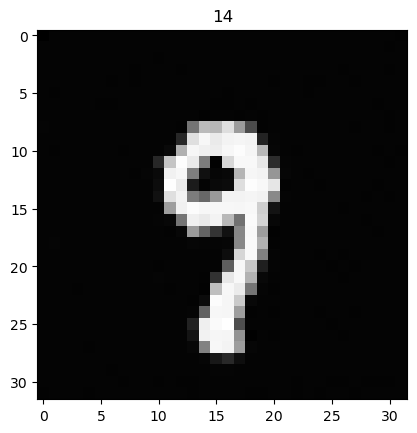

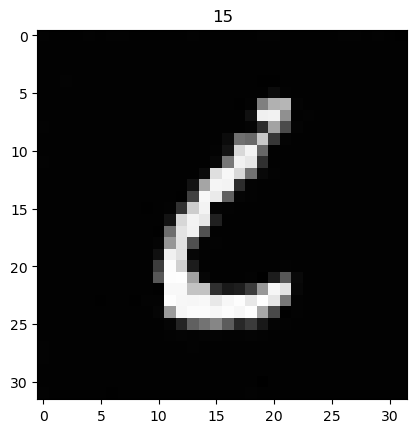

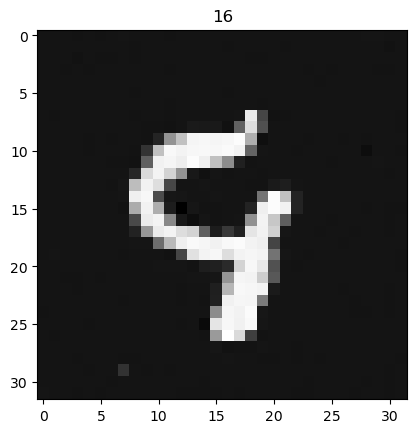

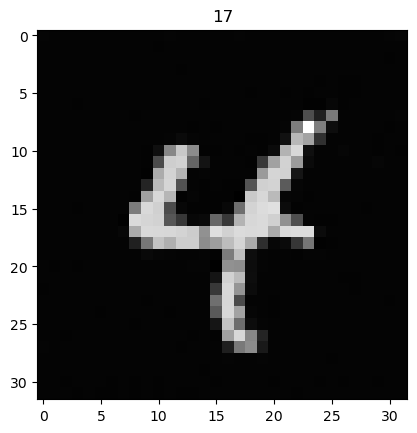

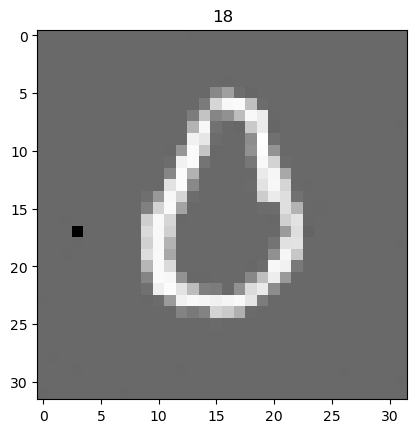

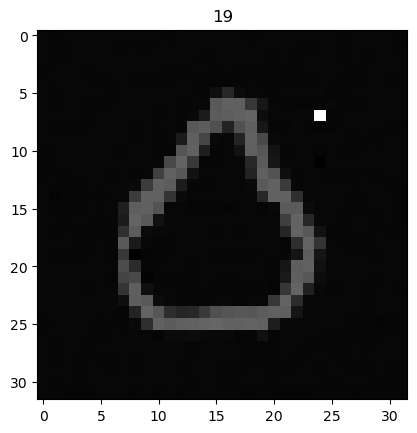

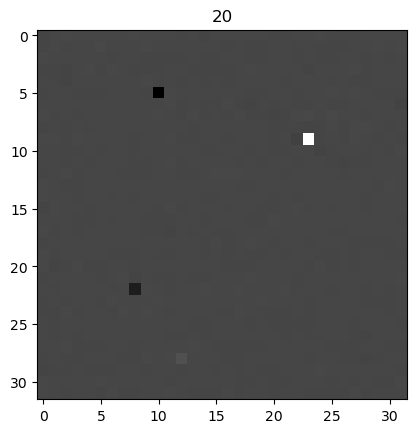

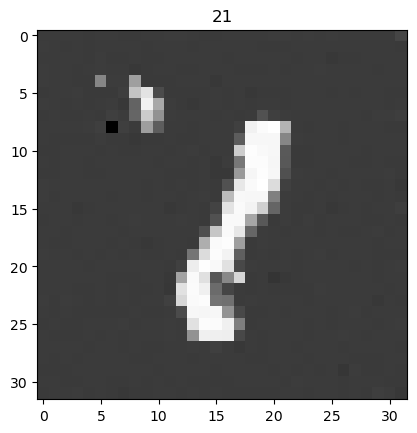

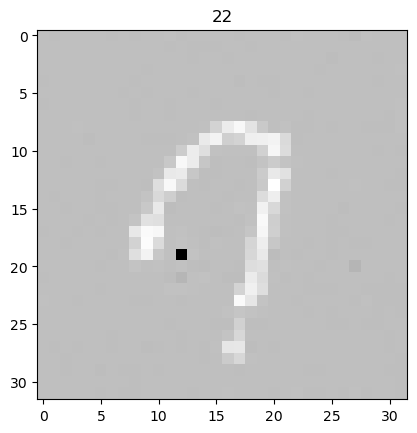

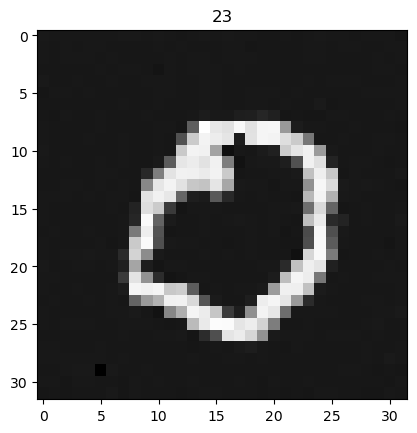

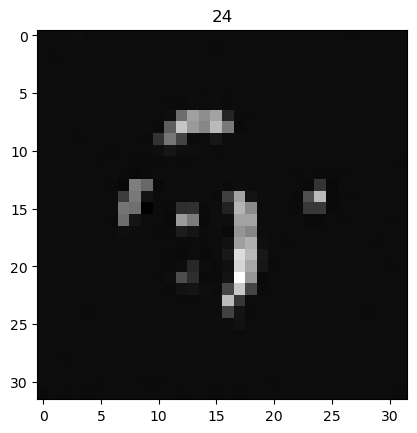

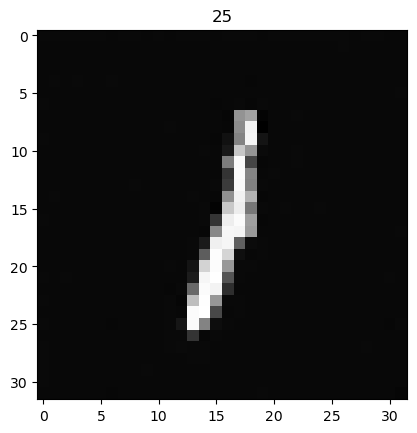

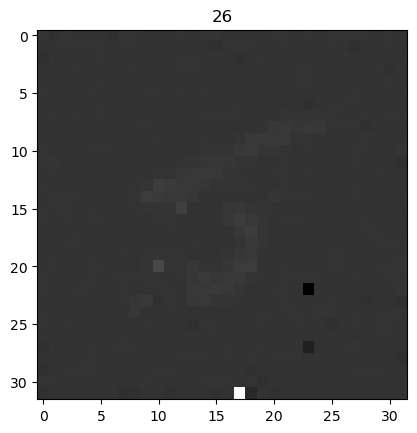

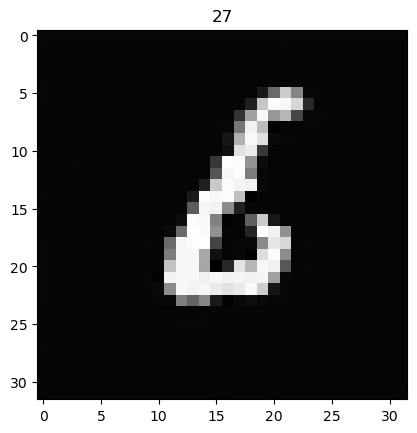

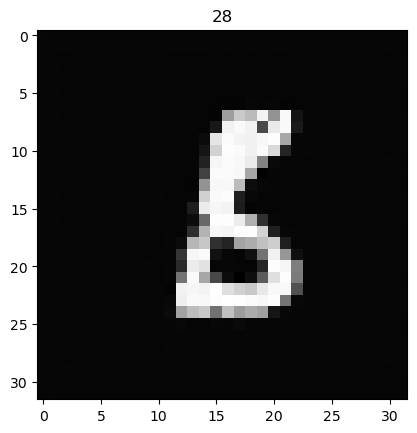

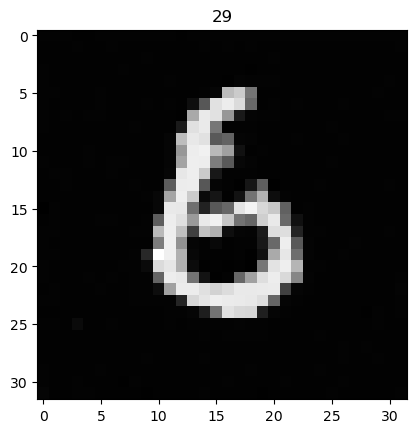

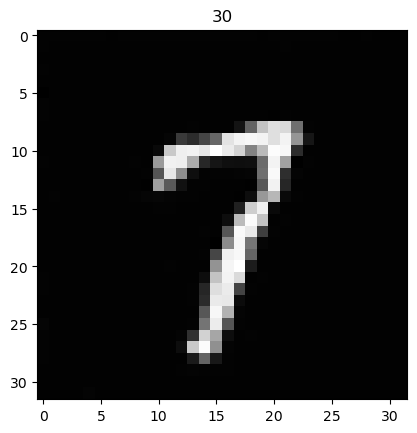

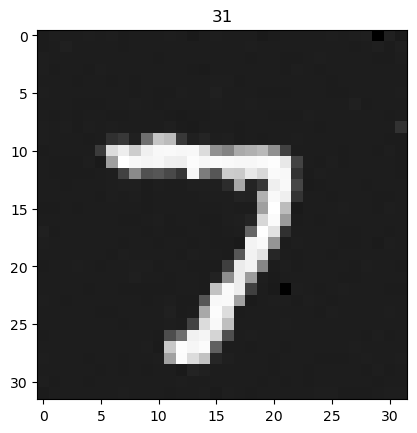

In [82]:
for i in range(gen_model.samples.size()[0]):
    plt.imshow(gen_model.samples[i][0], cmap='gray')
    plt.title('{}'.format(i))
    plt.show()

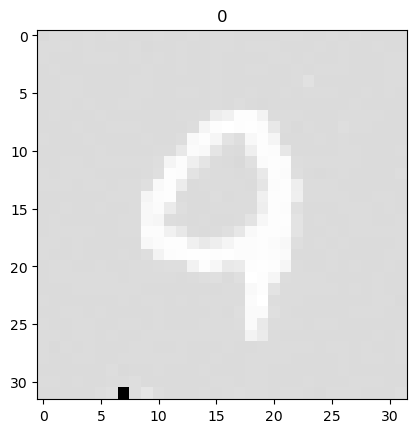

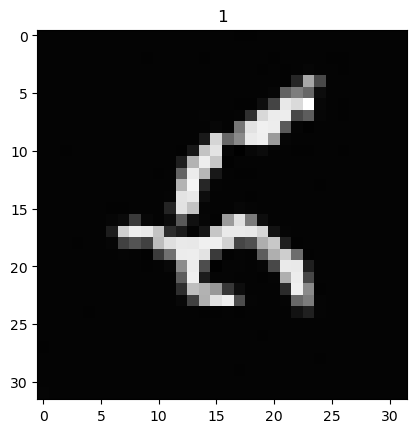

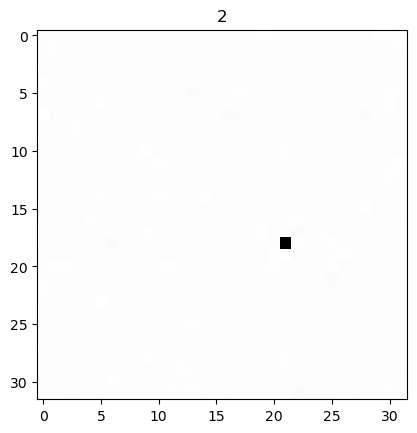

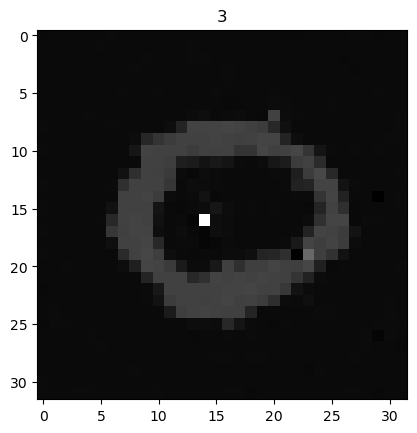

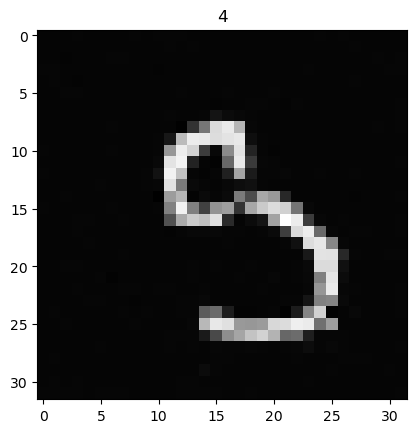

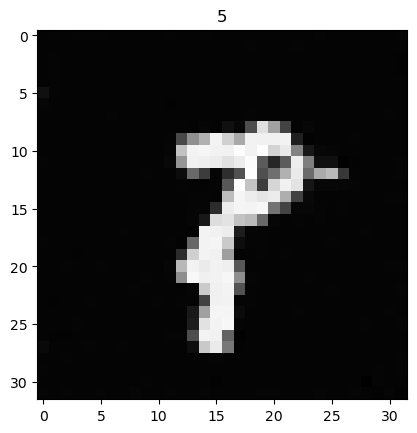

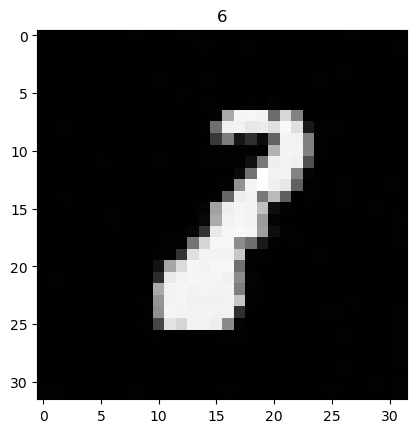

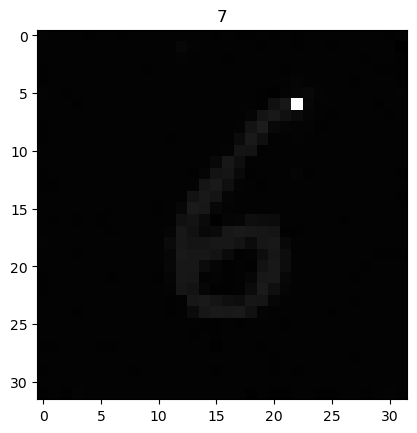

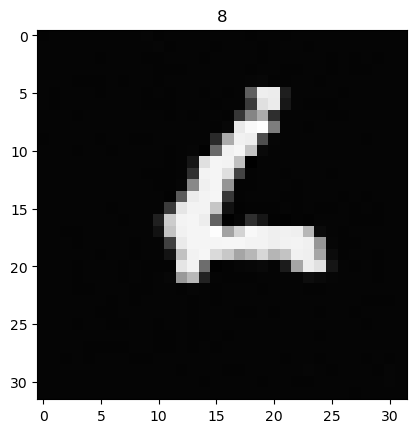

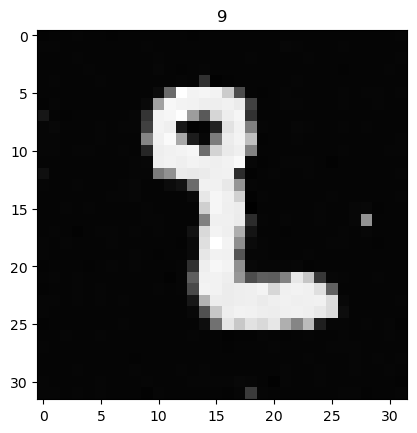

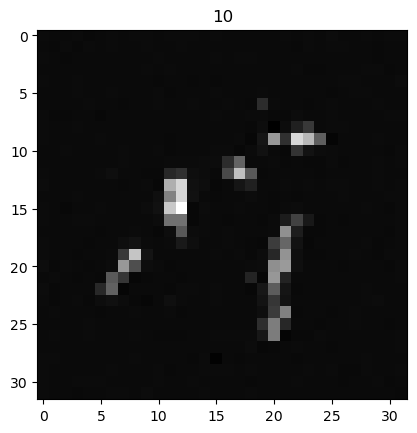

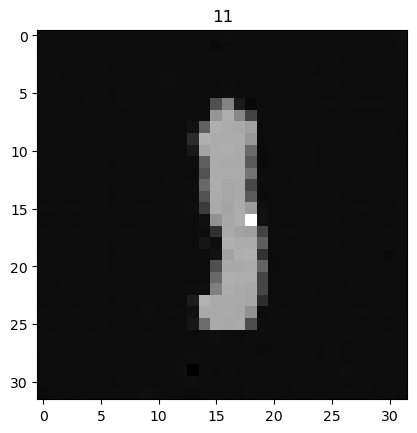

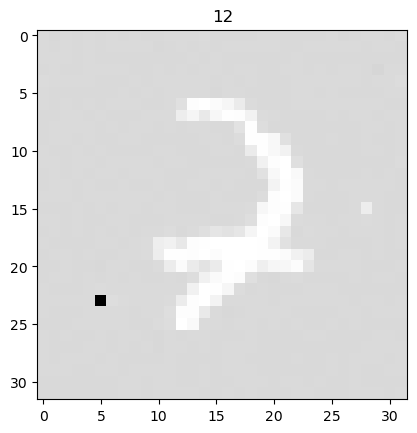

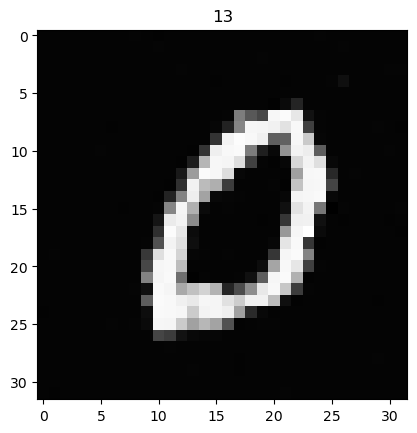

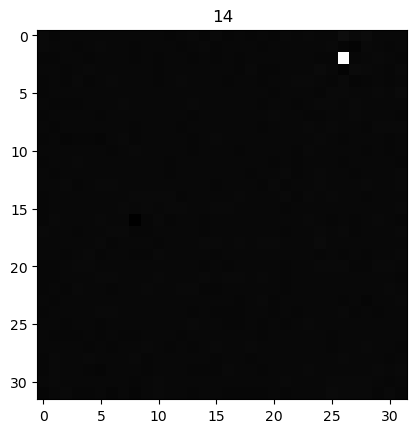

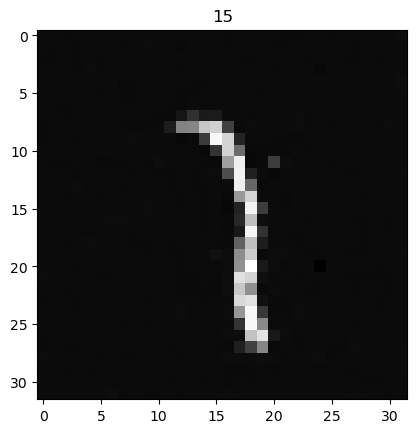

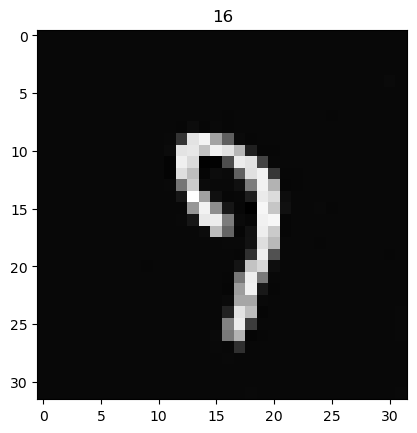

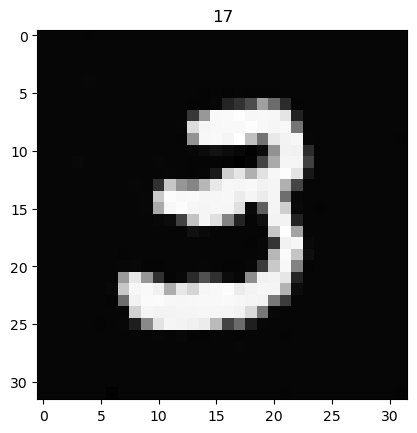

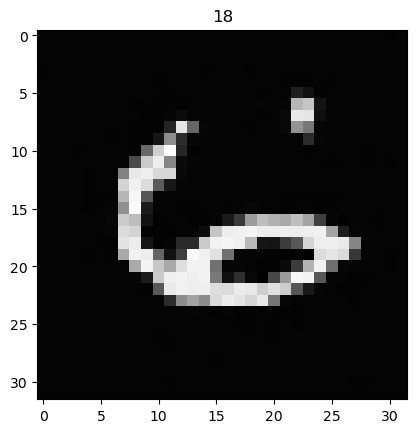

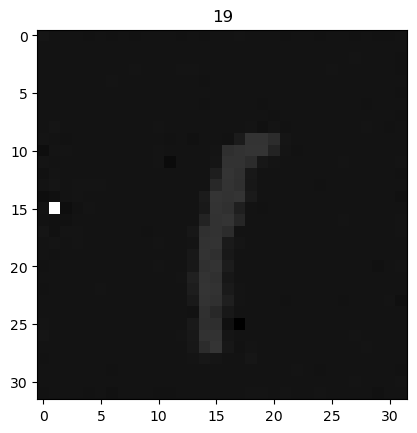

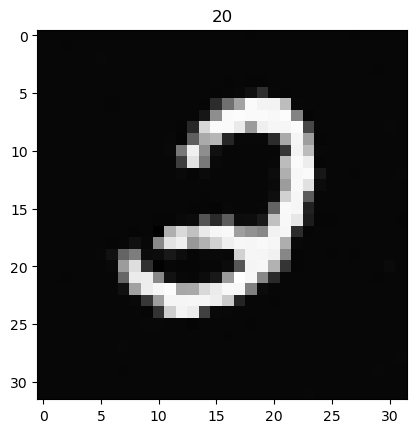

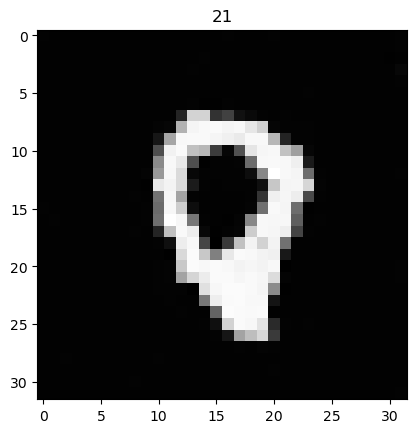

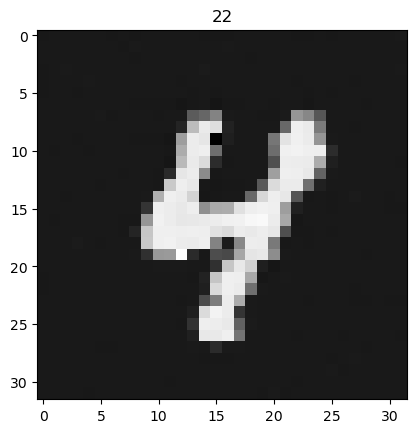

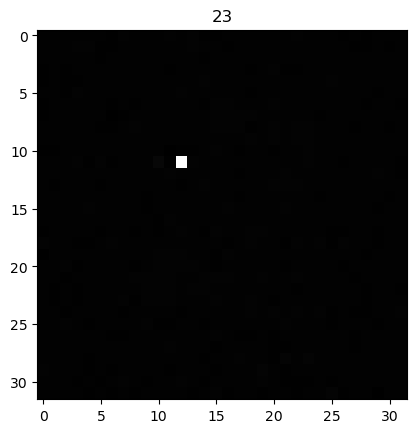

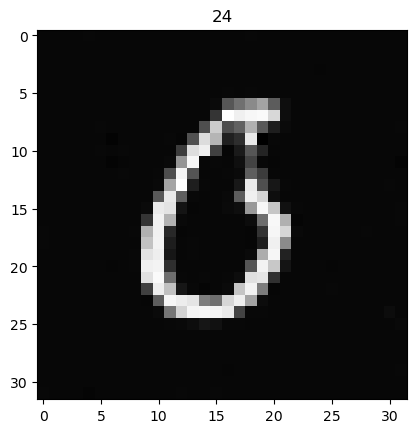

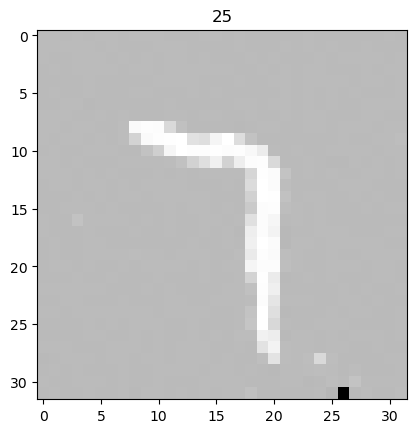

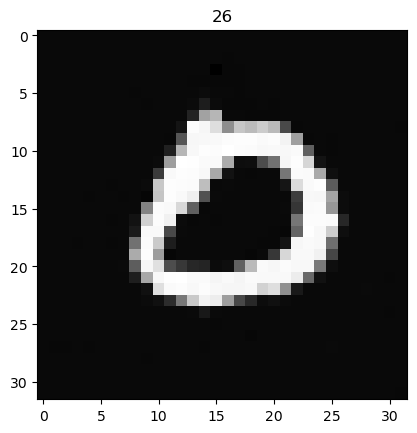

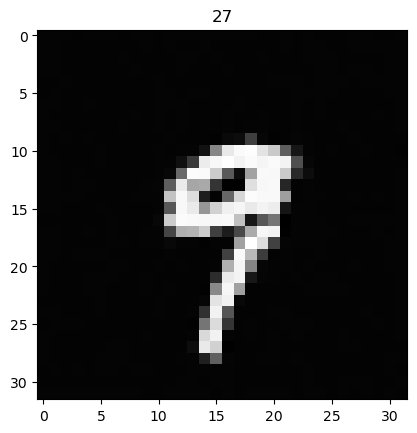

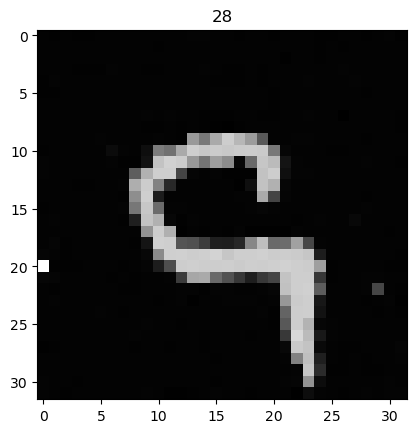

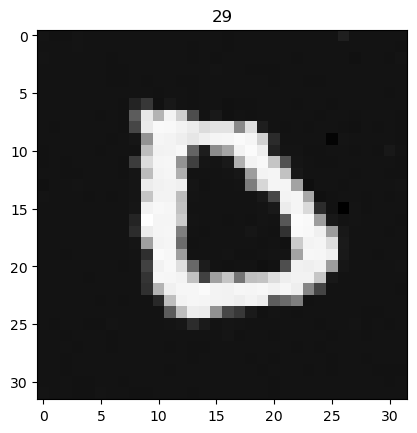

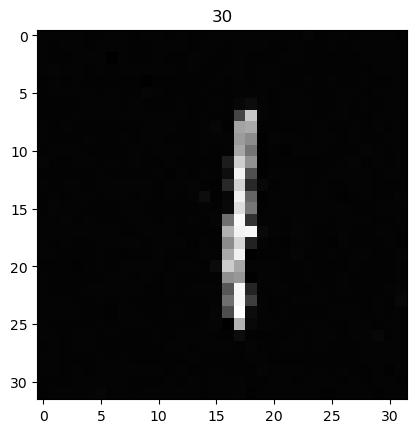

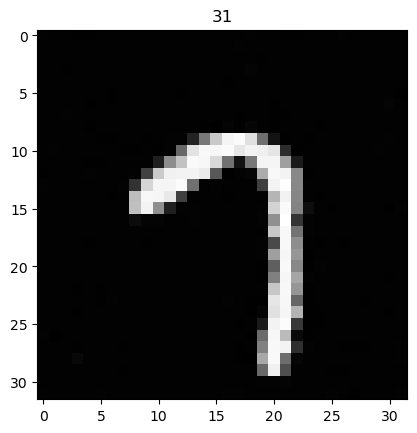

In [77]:
for i in range(gen_model.samples.size()[0]):
    plt.imshow(gen_model.samples[i][0], cmap='gray')
    plt.title('{}'.format(i))
    plt.show()

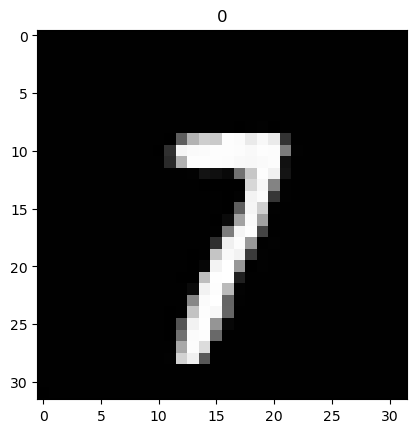

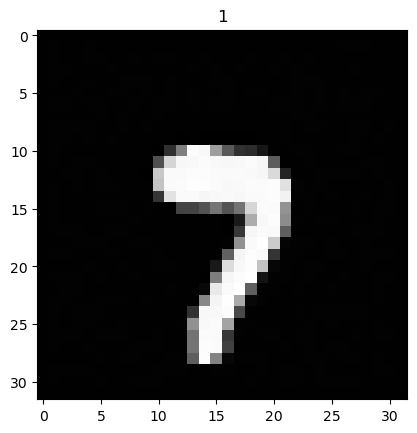

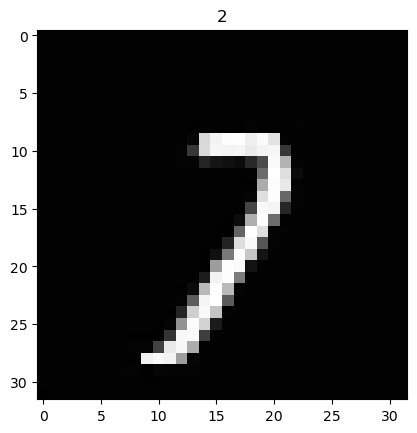

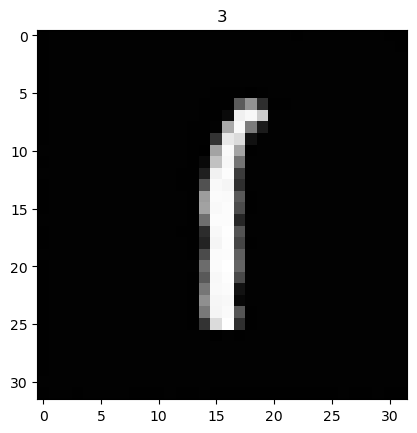

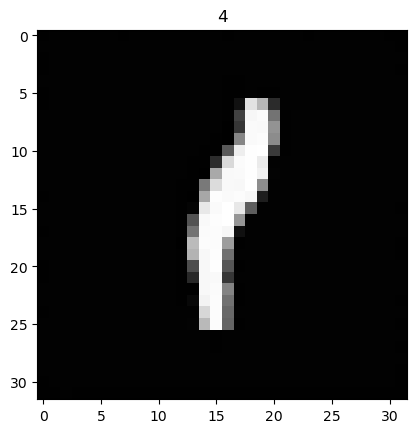

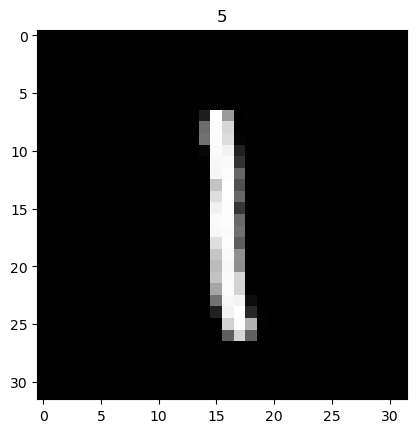

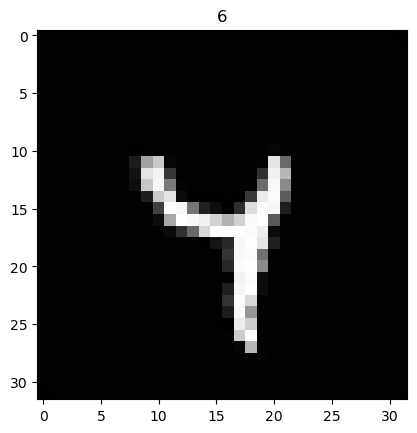

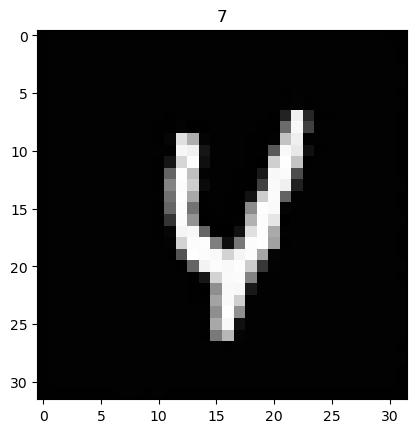

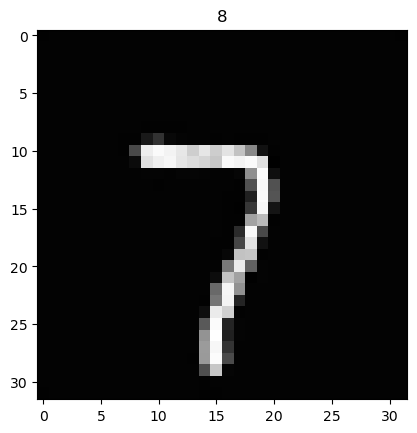

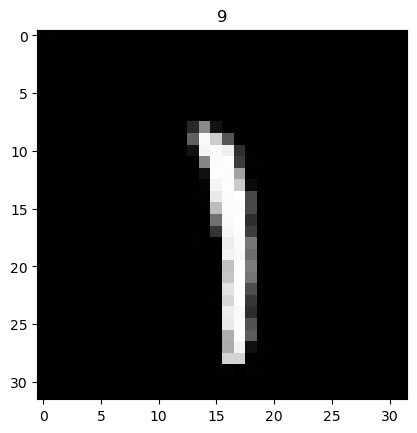

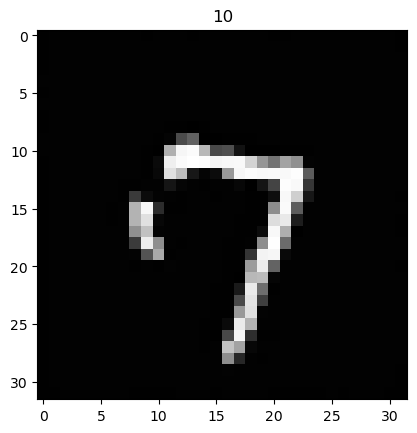

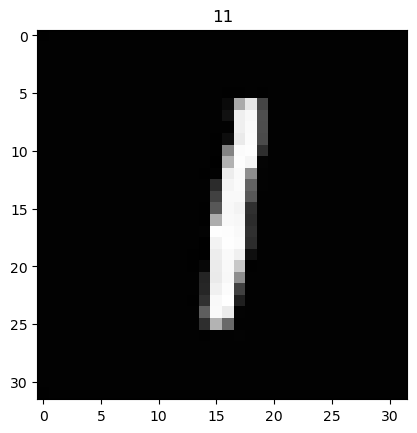

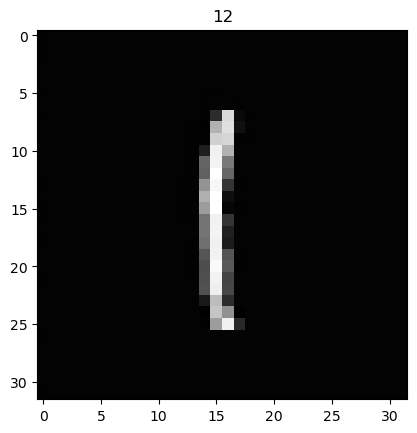

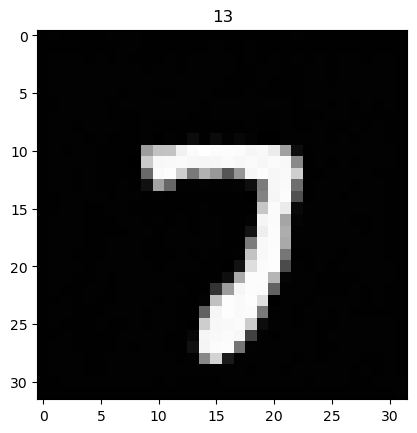

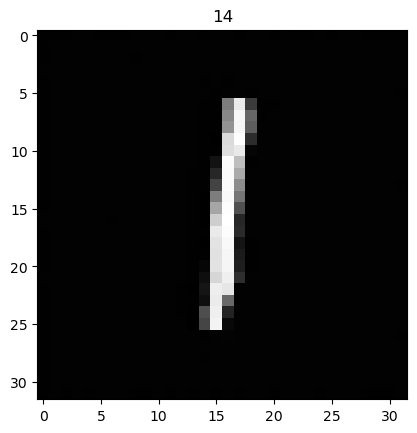

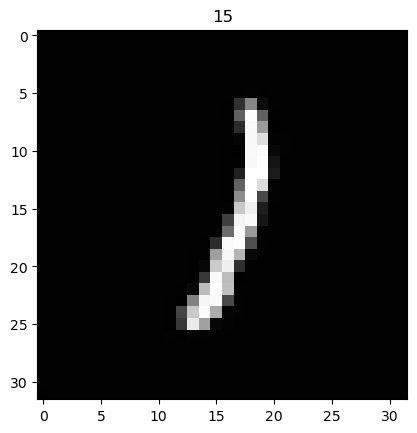

In [72]:
for i in range(gen_model.samples.size()[0]):
    plt.imshow(gen_model.samples[i][0], cmap='gray')
    plt.title('{}'.format(i))
    plt.show()

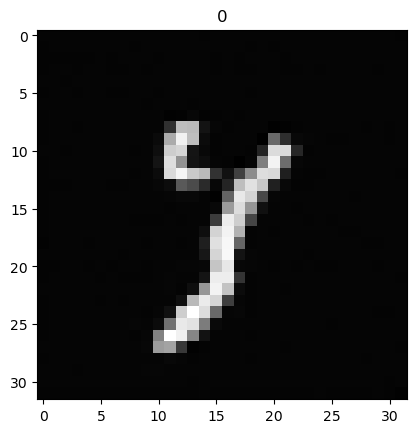

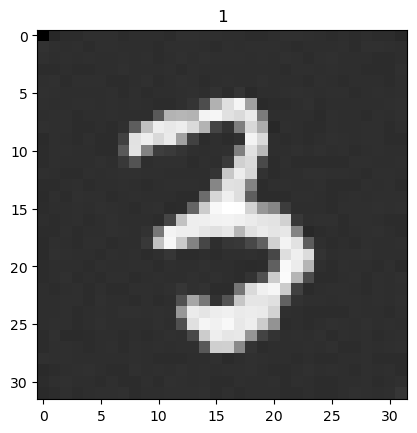

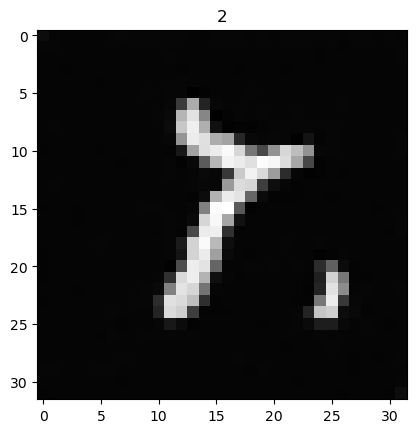

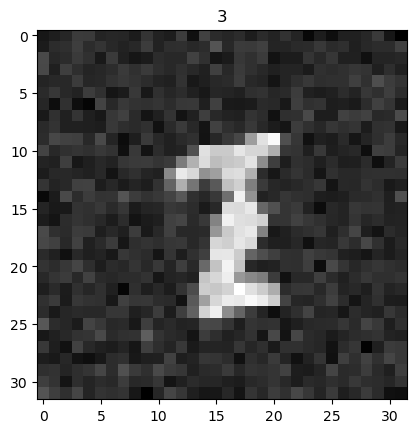

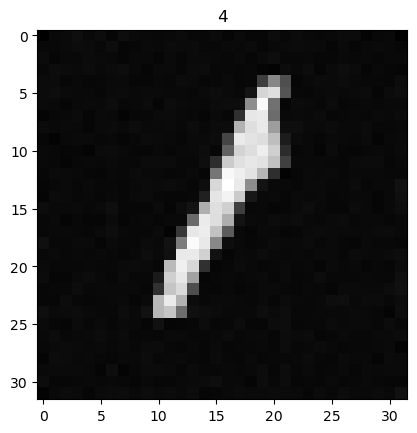

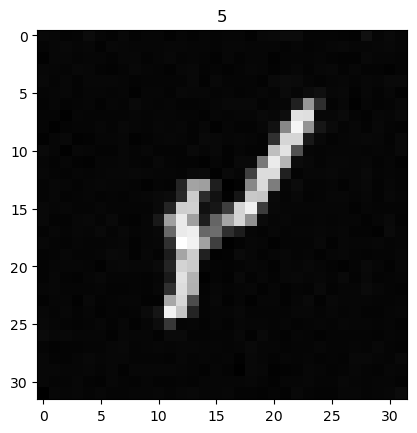

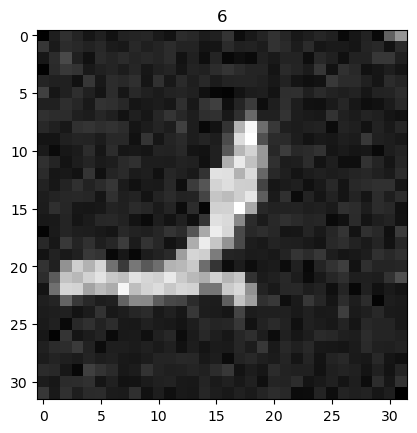

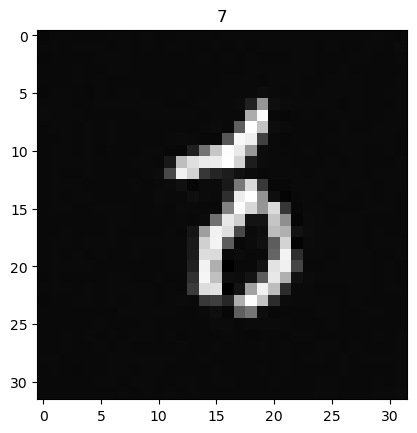

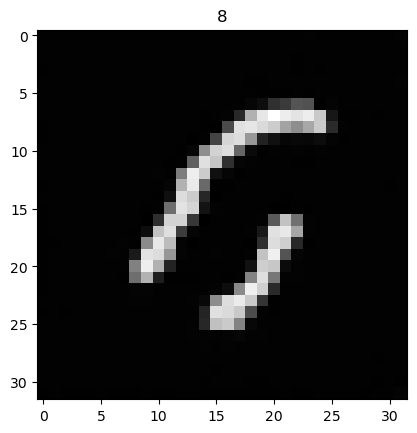

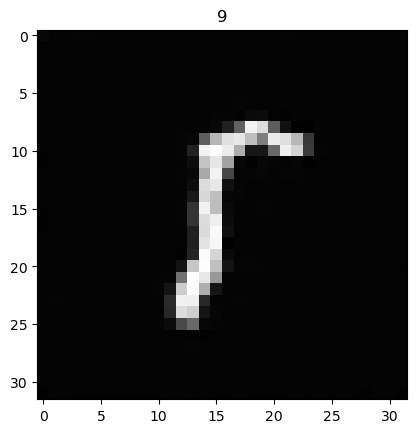

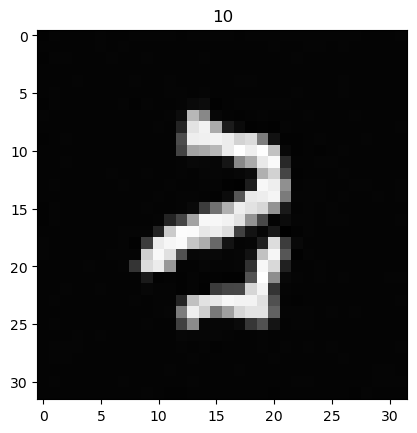

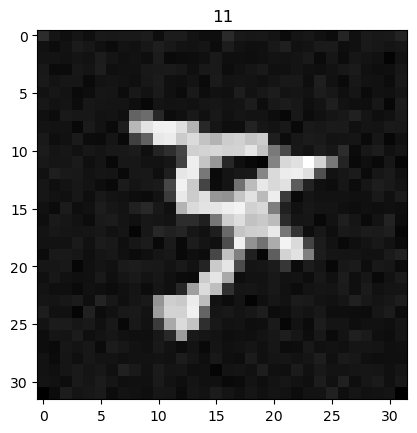

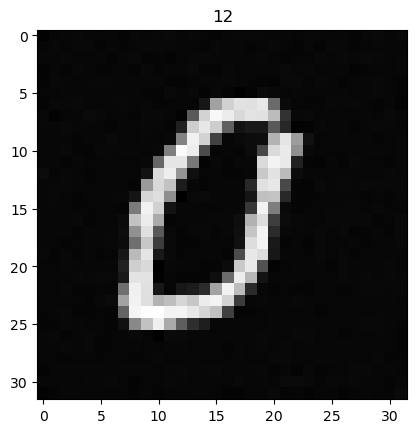

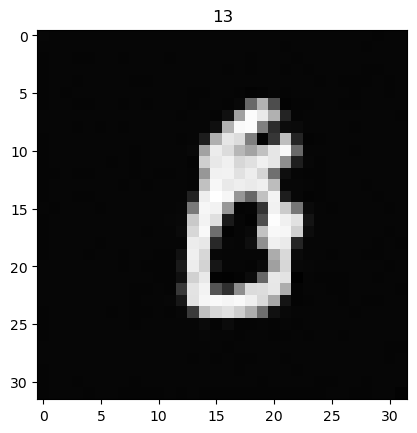

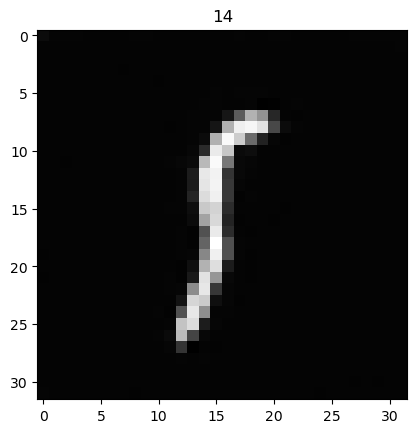

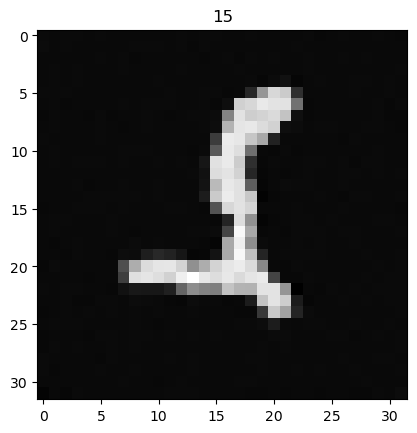

In [61]:
for i in range(gen_model.samples.size()[0]):
    plt.imshow(gen_model.samples[i][0], cmap='gray')
    plt.title('{}'.format(i))
    plt.show()

In [101]:
checkpoint = {
            'model_parameters': model.state_dict(),
            'optimizer': model.optimizer.state_dict()
        }
torch.save(checkpoint, 'models/unet/mnist_2.0.pt')

Communication with Neptune restored!
Communication with Neptune restored!


* test saving and loading of model ok
* make a function to automate training/resuming training of a model, and saving at the end of iterations. Offer possibility to cut training short and save. ok
* make argparse, with convenient default parameters. ok
* or make ini file from which to load ok
* integrate evaluations to training loop. 
* upload pictures to neptune. specify hash of parameters in uploaded parameters in neptune
* Also specify noising schedule in parameters
* change from a_t as input to a_t as conditioning

Problems:
* When resuming a run, we are running on new data; this is why loss kind of resets
* Works very well after an evaluation on training mode rather then eval mode... wtf??? Seems like this is because of dropout (why?) and bacth norm. For batch norm this is because there is momentum to computed expectancy and variance parameters. Since our data is heavy tailed, empirical variance increases with number of samples. So we should use batch_size amount of data for evaluation.
* works reaaly reaaly well when batch norm + generation of batch_size points. What?

Remark:
* Lploss: higher Lp loss really sanctions far away samples.

# Train model and upload on neptune

In [15]:
with open(os.path.join("DDLM/configs", 'mnist.yml'), "r") as f:
    config = yaml.safe_load(f)

In [4]:
import os
import yaml
import argparse
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(os.path.join("DDLM/configs", 'tmp.yml'), "r") as f:
    config = yaml.safe_load(f)
    config = dict2namespace(config)

    

# TODO: move 'LIM', 'LIM_config' etc to diffusion

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True, # shit
    'dropout_rate' : .1,
    'nblocks' : 2,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, # must be even. I'd say must be superior to diffusion steps other wise bad performance
    #'nfeatures' : n_features,
    'compute_gamma': False,
    #'exp_block': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'sas_grid',
    'std' : 0.01, # 0.5, 0.05,
    'n_mixture' : 9, # must be square. set to None if not a grid mixture
    'normalized' : True,
    #'weights': np.array([1/2]*2),
    'weights': [.01, .1, .3, 
                .2, .02, .15,
                .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'data_alpha': 1.8,
    'isotropic': True
}

p_training_2d = {
    'lr' : 1e-2,
    'schedule': 'linear',
    'warmup': 0,
    'lr_steps': 500000,
    'grad_clip': 5., # None
    'bs' : 6*1024,
    'optimizer': 'adamw',
    #'use_lambda' : False, # use lambda factor in loss
    'loss_type': Diffusion.LossType.LP_EPS_LOSS,
    'lploss': 1.0, # p in Lploss
    'monte_carlo_steps': 1, # for each t, x_0, z_t, number of different a_t_1, a_t' to generate
    'loss_monte_carlo': 'mean', #loss to apply on batch of M number of a's. can be mean or median
    'ema_rates': [.99, .9, 0.],
}

p_eval_2d = {
    'ddim': False,
    'eval_eta': 1.,
    'reduce_timesteps': 1.,
    'data_to_generate': 256,
    'fig_type': 'scatter_plot'
}

p_model_unet = {
    'model_channels': 32, # 128
    'dropout': .1,
    'compute_gamma': False,
}

p_data_unet = {
    'dataset': 'mnist',
    'num_workers': 4,
}

p_training_unet = {
    'lr' : 1e-3,
    'schedule': 'linear',
    'warmup': 0,
    'lr_steps': 500000,
    'grad_clip': 5., # None
    'bs' : 256, # may need to remove
    'optimizer': 'adamw',
    #'use_lambda' : False, # use lambda factor in loss
    'loss_type': Diffusion.LossType.LP_EPS_LOSS,
    'lploss': 1.0, # p in Lploss
    'monte_carlo_steps': 5, # for each t, x_0, z_t, number of different a_t_1, a_t' to generate
    'loss_monte_carlo': 'median', #loss to apply on batch of M number of a's. can be mean or median
    'ema_rates': [.9, .7],
}

p_eval_unet = {
    'ddim': True,
    'eval_eta': 0.,
    'reduce_timesteps': 20.,
    'data_to_generate': 128,
    'fig_type': 'image'
}

def get_p(unet = True):
    p = {
        #'LIM': False,

        'diffusion': {
            #'LIM': False,
            #'LIM_args': config,
            #'LIM_config': config,
            
            'alpha' : 2.,
            'diffusion_steps' : 1000 if unet else 50,
            
            'mean_predict': Diffusion.ModelMeanType.EPSILON,
            'var_predict': Diffusion.ModelVarType.FIXED, # fixed, gamma, log_gamma, true_variance, log_var...
            'isotropic': True,
            'rescale_timesteps': True,
            'clamp_a' : 20,
            'clamp_eps' : 2000
        },

        # 'device': device, # mps, cuda or cpu
    }
    if unet:
        p['model'] = p_model_unet
        p['data'] = p_data_unet
        p['training'] = p_training_unet
        p['eval'] = p_eval_unet
    else:
        p['model'] = p_model_2d
        p['data'] = p_data_2d
        p['training'] = p_training_2d
        p['eval'] = p_eval_2d
    return p

use_unet = True
p = get_p(unet = use_unet)

In [23]:
with open('DDLM/configs/2d_data.yml', 'w') as outfile:
    yaml.dump(p, outfile, default_flow_style=False)

## Experiment some loss types and monte carlo steps

* monte carlo

In [ ]:
for monte_carlo_steps in [1]:
    for loss_monte_carlo in ['mean']:
        p['diffusion']['alpha'] = 2.0
        p['training']['monte_carlo_steps'] = monte_carlo_steps
        p['training']['loss_monte_carlo'] = loss_monte_carlo
        exp = Exp.Experiment(p, 'models/monte_carlo_2.0')
        exp.prepare(logger = Logger.NeptuneLogger(), legacy = True)# Logger.NeptuneLogger())
        exp.run(600, 50, None, lploss=1.0, progress=True, eval_eta=1.)
        exp.save()

* Use mean loss or epsilon loss while outputting epsilon from the model

In [ ]:
for loss_type in [Diffusion.LossType.LP_EPS_LOSS, Diffusion.LossType.LP_MEAN_LOSS]:
    p['training']['loss_type'] = loss_type
    exp = Exp.Experiment(p, 'models/loss_type')
    exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())
    exp.run(200, 50, None, lploss=1.0, progress=False, eval_eta=1.)
    exp.save()

* output either mean or epsilon, with mean loss

In [ ]:
for mean_predict in [Diffusion.ModelMeanType.PREVIOUS_X, Diffusion.ModelMeanType.EPSILON]:
    p['diffusion']['mean_predict'] = mean_predict
    exp = Exp.Experiment(p, 'models/mean_predict')
    exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())
    exp.run(200, 50, None, lploss=1.0, progress=False, eval_eta=1.)
    exp.save()

* mean or median loss

In [ ]:
for loss_batch in ['median', 'mean']:
    p['training']['loss_batch'] = loss_batch
    exp = Exp.Experiment(p, 'models/loss_batch')
    exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())
    exp.run(200, 50, None, lploss=1.0, progress=False, eval_eta=1.)
    exp.save()

## Experiments for Flow lines, see how DDIM and Gamma training affect output

In [ ]:
p['data']['nfeatures'] = 1
p['data']['weights'] = np.array([1/9]*9) # will just give 3 equally weighted mixture in 1d

for data_alpha in [2.0, 1.8]:
    for diffusion_alpha in [2.0, 1.8]:
        p['data']['data_alpha'] = data_alpha
        p['diffusion']['alpha'] = diffusion_alpha
        # predicting mean
        print('mean, data:{}, diffusion:{}'.format(data_alpha, diffusion_alpha))
        p['training']['loss_type'] = Diffusion.LossType.LP_EPS_LOSS
        p['diffusion']['mean_predict'] = Diffusion.ModelMeanType.EPSILON
        p['diffusion']['var_predict'] = Diffusion.ModelVarType.FIXED
        p['model']['compute_gamma']= False
        exp = Exp.Experiment(p, 'models/flows_400')
        exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())
        exp.run(400, 50, None, lploss=1.0, progress=False, eval_eta=1.)
        exp.save()
        # predicting var
        print('mean and gamma, data:{}, diffusion:{}'.format(data_alpha, diffusion_alpha))
        p['training']['loss_type'] = Diffusion.LossType.VAR_KL
        p['diffusion']['mean_predict'] = Diffusion.ModelMeanType.EPSILON
        p['diffusion']['var_predict'] = Diffusion.ModelVarType.GAMMA
        p['model']['compute_gamma']= True
        exp = Exp.Experiment(p, 'models/flows_400')
        exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())
        exp.run(400, 50, None, lploss=1.0, progress=False, eval_eta=1.)
        exp.save()
        # predicting sqrt gamma
        print('sqrt gamma epsilon, data:{}, diffusion:{}'.format(data_alpha, diffusion_alpha))
        p['training']['loss_type'] = Diffusion.LossType.LP_MEAN_LOSS
        p['diffusion']['mean_predict'] = Diffusion.ModelMeanType.SQRT_GAMMA_EPSILON
        p['diffusion']['var_predict'] = Diffusion.ModelVarType.FIXED
        p['model']['compute_gamma']= False
        exp = Exp.Experiment(p, 'models/flows_400')
        exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())
        exp.run(400, 50, None, lploss=1.0, progress=False, eval_eta=1.)
        exp.save()

## Experiment with jump layer

In [ ]:
for exp_block in [True, False]:
    p['model']['exp_block'] = exp_block
    if not exp_block:
        p['model']['nblocks'] *= 2
    exp = Exp.Experiment(p, 'models/exp_block')
    exp.prepare(logger = Logger.NeptuneLogger(), legacy = True)# Logger.NeptuneLogger())
    exp.run(500, 50, None, lploss=1.0, progress=True, eval_eta=1.)
    exp.save()
    if not exp_block:
        p['model']['nblocks'] /= 2
    exp.terminate()

## Experiment LIM vs Us

In [ ]:
p['LIM'] = False
p['monte_carlo_steps'] = 5
p['loss_monte_carlo'] = 'median'
exp = Exp.Experiment(p, 'models/levy_median_5')
exp.prepare(logger = Logger.NeptuneLogger(), legacy = True)# Logger.NeptuneLogger())
exp.run(500, 50, None, lploss=1.0, progress=True, eval_eta=1.)
exp.save()
exp.terminate()

In [ ]:
for LIM in [True, False]:
    p['LIM'] = LIM
    exp = Exp.Experiment(p, 'models/lim_vs_levy_fixed')
    exp.prepare(logger = Logger.NeptuneLogger(), legacy = True)# Logger.NeptuneLogger())
    exp.run(500, 50, None, lploss=1.0, progress=True, eval_eta=1.)
    exp.save()
    exp.terminate()

In [ ]:
for LIM in [True, False]:
    for alpha in [2.0, 1.99, 1.9, 1.8, 1.6]:
        for data_alpha in [2.0, 1.99, 1.9, 1.8, 1.6]:
            p['LIM'] = LIM
            exp = Exp.Experiment(p, 'models/lim_vs_levy')
            exp.prepare(logger = Logger.NeptuneLogger(), legacy = True)# Logger.NeptuneLogger())
            exp.run(500, 50, 50, lploss=1.0, progress=True, eval_eta=1.)
            exp.save()
            exp.terminate()

# Automated Experiments

## are forward coefficients the same??

In [55]:
bg = exp.manager.diffusion.bargammas
tmp_sde = exp.manager.diffusion.sde

t = torch.arange(60)
alpha = p['diffusion']['alpha']
t_sde = tmp_sde.T * t / p['diffusion']['diffusion_steps']
x_coeff = (bg[t]**(1/alpha)).cpu()
x_coeff_sde = tmp_sde.diffusion_coeff(t_sde)

s_coeff = ((1 - bg[t])**(1/alpha)).cpu()
s_coeff_sde = tmp_sde.marginal_std(t_sde)
#print((s_coeff - s_coeff_sde) / s_coeff_sde)
#print((x_coeff - x_coeff_sde) / x_coeff_sde)
#print(x_coeff)
#print(x_coeff - x_coeff_sde)
#print(s_coeff)
#print(s_coeff - s_coeff_sde)

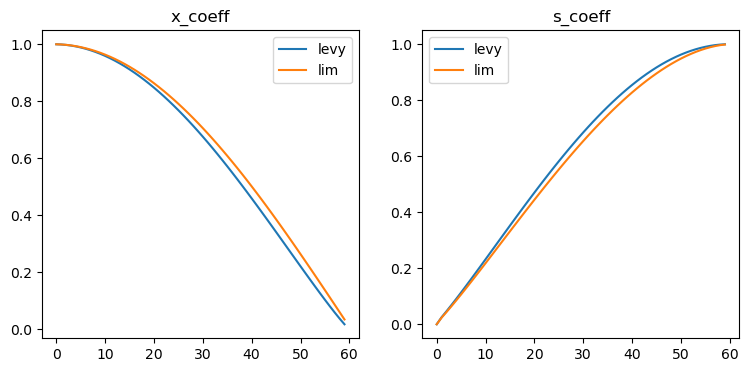

In [56]:
fig = plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(t, x_coeff, label = 'levy')
plt.plot(t, x_coeff_sde, label = 'lim')
plt.title('x_coeff')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t, s_coeff, label = 'levy')
plt.plot(t, s_coeff_sde, label = 'lim')
plt.title('s_coeff')
plt.legend()
plt.show()

* Not exactly. only other difference is the distribution of $t$ : U(0, T) vs U(eps, sde.T)
* and sde.T: # For the cosine schedule, T = 1 will have numerical issues. So we manually set the ending time T.
            # Note that T = 0.9946 may be not the optimal setting. However, we find it works well.

## normal training

In [7]:
importlib.reload(Data)
importlib.reload(Model)
importlib.reload(Distrib)
importlib.reload(Algo)
importlib.reload(Gen)
importlib.reload(Manager)
importlib.reload(Exp)
importlib.reload(utils)
importlib.reload(Train)
importlib.reload(Logger)
importlib.reload(unet)
importlib.reload(Diffusion)
importlib.reload(Eval)
importlib.reload(LIM_sampler)
importlib.reload(LIM_sde)

<module 'LevyDiffusion.LIM.functions.sde' from '/Users/dshariat/inria/levy_diffusion/LevyDiffusion/LevyDiffusion/LIM/functions/sde.py'>

In [1]:
import numpy as np
import torch
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import DDLM.manage.Experiments as Exp


In [2]:
with open(os.path.join("DDLM/configs", 'mnist.yml'), "r") as f:
    p = yaml.safe_load(f)
exp = Exp.Experiment('models/tmp', p, logger = None)
#exp.prepare(logger = None, unet = use_unet)# Logger.NeptuneLogger())
#exp.prepare()

using device mps


In [3]:
checkpoint = torch.load('./models/mnist/model_febf5311e139a4af.pt', map_location=torch.device(exp.manager.diffusion.device))

In [4]:
exp.manager.model.load_state_dict(checkpoint['model_parameters'])
exp.manager.optimizer.load_state_dict(checkpoint['optimizer'])

In [9]:
exp.load()

In [ ]:
exp.run(epochs = 1, 
        eval_freq = 1, 
        checkpoint_freq = 1, 
        lploss = 1.,
        progress=True)
exp.manager.display_losses()

In [10]:
from LevyDiffusion.LIM.evaluate.fid_score import fid_score, prdc
import torchvision.utils as tvu

In [11]:
# generate some data
n_samples = 128
gen_model = Gen.GenerationManager(exp.manager.model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.generate(n_samples, eta=1., ddim = False, print_progression = True, get_sample_history=False, reduce_timesteps = 1.)

100%|███████████████████████████████████████▉| 999/1000 [01:16<00:00, 13.08it/s]


In [12]:
original_data = gen_model.load_original_data(n_samples)

In [30]:
gen_samples = gen_model.samples.squeeze(1)

In [31]:
# save some original data in folder
for i in range(n_samples):
    tvu.save_image(
        gen_samples[i], os.path.join('eval_files/generated_data', f"{i}.png")
    )
    tvu.save_image(
        original_data[i], os.path.join('eval_files/original_data', f"{i}.png")
    )

In [32]:
fid_value = fid_score('eval_files/original_data', 
                      'eval_files/generated_data', 
                      n_samples, 
                      exp.manager.diffusion.device, 
                      num_workers=0)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


In [33]:
fid_value

50.45375782762798

In [35]:
prdc('eval_files/original_data', 
     'eval_files/generated_data', 
     n_samples, 
     exp.manager.diffusion.device, 
     num_workers=0)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


real_features : (128, 2048)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]

fake_features : (128, 2048)
Num real: 128 Num fake: 128
{'precision': 0.90625, 'recall': 0.9609375, 'density': 0.7625000000000001, 'coverage': 0.953125}


In [ ]:
exp.run(2, 250, None, lploss = 1., progress=True, ddim = True, eval_eta = 0.)
#exp.model.alpha = 1.8
#exp.run(150, 200, None, Lploss = 1.0)
exp.manager.display_losses()

In [39]:
n = 4096  
x_shape = (n, 1, 2)
init_clamp = config.sampling.init_clamp

In [40]:
import LevyDiffusion.LIM as LIM
tmp_sde = LIM.functions.sde.VPSDE(config.diffusion.alpha, config.diffusion.beta_schedule)
tmp_levy = LIM.torchlevy.LevyStable()

In [41]:
if tmp_sde.alpha == 2.0:
    # Gaussian noise
    x = torch.randn(x_shape).to(p['device'])
else:
    if config.diffusion.is_isotropic:
        # isotropic
        x = tmp_levy.sample(alpha=tmp_sde.alpha, size=x_shape, is_isotropic=True, clamp=init_clamp).to(p['device'])
    else:
        # non-isotropic
        x = torch.clamp(self.levy.sample(self.sde.alpha, size=x_shape, is_isotropic=False, clamp=None).to(p['device']), 
                        min=-init_clamp, max=init_clamp)

if config.model.is_conditional:
    if config.sampling.cond_class is not None: 
        y = torch.ones(n) * configs.sampling.cond_class
        y = y.to(p['device'])
        y = torch.tensor(y, dtype=torch.int64)
    else:
        y = None
else:
    y = None

In [42]:
x = LIM.functions.sampler.LIM_sampler(config, 
                                      config, 
                                      x, 
                                      y, 
                                      exp.manager.model, 
                                      tmp_sde, 
                                      tmp_levy,
                                     device=p['device'])

100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 96.57it/s]


In [43]:
gen_model = Gen.GenerationManager(exp.model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.samples = x.cpu()

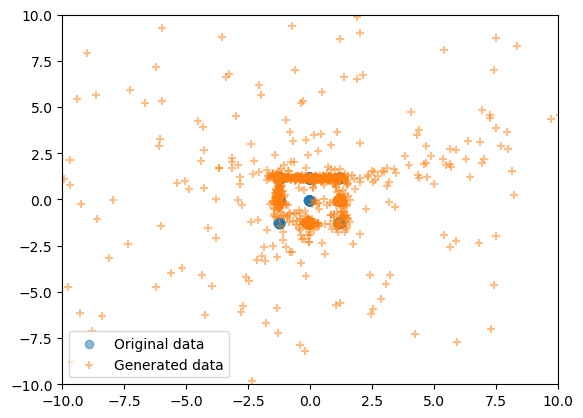

In [44]:
fig = gen_model.get_plot(xlim = (-10, 10), ylim = (-10, 10))
display(fig)

In [7]:
exp.save()

('models/flows/gmm_2/model_c5315d7745a4e5aa.pt',
 'models/flows/gmm_2/parameters_c5315d7745a4e5aa.pt',
 'models/flows/gmm_2/eval_c5315d7745a4e5aa.pt')

* Models trained on $\alpha= 2.0$ are good starting points for other alphas.

# Generate MNIST

## Manual Experiments

In [45]:
model, data, manager = exp.prepare_experiment(p, use_neptune = False)

In [48]:
manager.train(20, batch_size = p['bs'], lr = p['lr']/1, L1Loss = True, eval_freq=5)

 30%|█████████████▏                              | 6/20 [00:02<00:10,  1.32it/s]

Epoch 5: 	loss = 0.7555046230554581 
		prd = [0.15510952 0.72362959] 
		wasserstein = 1.4877683638349488


 55%|███████████████████████▋                   | 11/20 [00:05<00:07,  1.28it/s]

Epoch 10: 	loss = 0.695164829492569 
		prd = [0.40884532 0.78675851] 
		wasserstein = 0.27811745121117426


 80%|██████████████████████████████████▍        | 16/20 [00:07<00:03,  1.28it/s]

Epoch 15: 	loss = 0.6695073843002319 
		prd = [0.43346962 0.84893625] 
		wasserstein = 0.27816380016740877


100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.97it/s]

Epoch 20: 	loss = 0.6536908149719238 
		prd = [0.44389745 0.83628407] 
		wasserstein = 0.24695575374652418


## Load and inspect

In [49]:
model, data, manager = exp.load_experiment_from_param(p, './models/tmp',use_neptune = False)

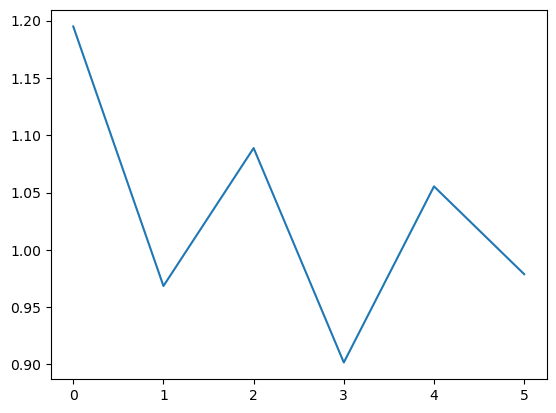

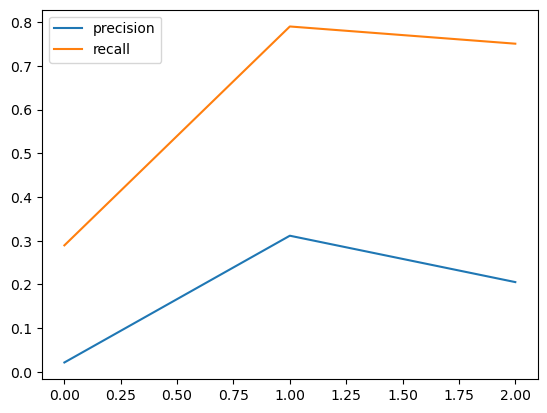

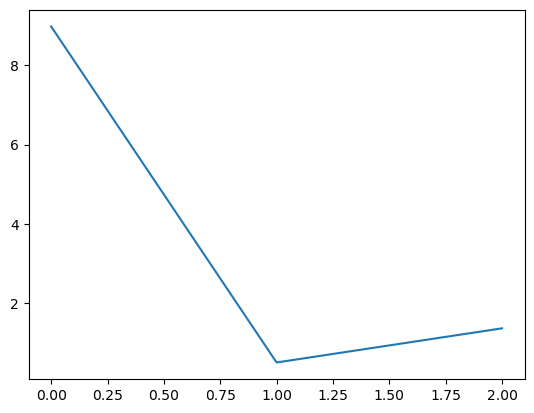

In [50]:
manager.display_losses()
manager.display_prd()
manager.display_wasserstein()

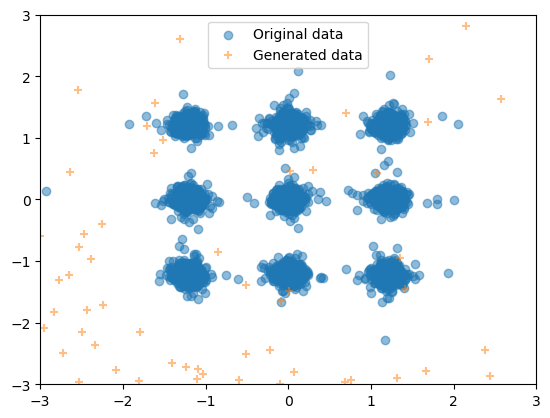

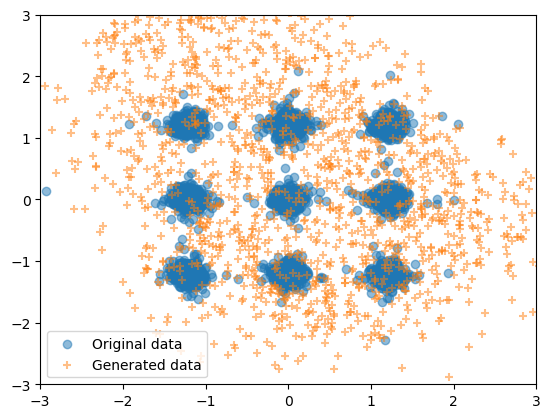

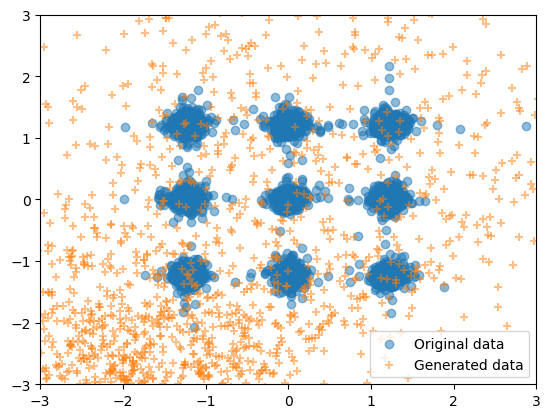

In [52]:
from LevyDiffusion.utils import display_figures
display_figures(manager.figures)

# Model Architecture

In [ ]:
from LevyDiffusion.utils import save_model_architecture
model.eval()
save_model_architecture(model, device, 'model')
model.train()

# Save

save etc and stop run

In [58]:
exp.save_experiment(p, './models/tmp', manager)

('./models/tmp/sas_grid/model_fe3212529d81c324.pt',
 './models/tmp/sas_grid/parameters_fe3212529d81c324.pt',
 './models/tmp/sas_grid/eval_fe3212529d81c324.pt')

In [166]:
manager.save('gmm_grid'+'_'+str(p['n_mixture']), './models/prd')

In [77]:
manager.save('swiss_roll', './models/prd')

# Generate

## ddim

In [216]:
def ddim_experiment_latent(eta):
    gen_model = Gen.GenerationManager(exp.model, 
                                  exp.manager.diffusion, 
                                  exp.data)
    tmp_alpha = 1.8
    tmp = Distrib.gen_sas(tmp_alpha, size = (2000, 1, 2), 
                                device =device,
                                isotropic = True)
    tmp_2 = Distrib.gen_sas(tmp_alpha, size = (2000, 1, 2), 
                                device =device,
                                isotropic = True)
    print('generating init samples')
    gen_model.generate(2000, eta = 0., use_samples=tmp, print_progression = False)
    init = gen_model.samples
    print(init)
    all_eps = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1]
    L = []
    for eps in all_eps:
        print('perturbating with eps={}'.format(eps))
        tmp_3 = tmp + eps*tmp_2
        tmp_3 /= (1 + eps**(tmp_alpha))**(1 / tmp_alpha)
        gen_model.generate(2000, eta = 0., use_samples=tmp_3, print_progression = False)
        new = gen_model.samples
        L.append(torch.linalg.norm(torch.nan_to_num(new) - torch.nan_to_num(init), ord = 2, dim = 1).mean())
    return all_eps, L

#latent_eta_1 = ddim_experiment_latent(1.)
#latent_eta_02 = ddim_experiment_latent(.2)
latent_eta_0 = ddim_experiment_latent(0.)

generating init samples
tensor([[[  0.5889,   7.0928]],

        [[ -0.0814,   1.1797]],

        [[  2.1265,   4.5692]],

        ...,

        [[ -1.3192,   1.1507]],

        [[-22.7791,  -8.8393]],

        [[ 62.9298, -31.7510]]])
perturbating with eps=0.0001
perturbating with eps=0.001
perturbating with eps=0.005
perturbating with eps=0.01
perturbating with eps=0.05
perturbating with eps=0.1
perturbating with eps=1


In [217]:
#print('eta = 1.0:')
#print(latent_eta_1[0])
#print(latent_eta_1[1])
#print('eta = .2:')
#print(latent_eta_02[0])
#print(latent_eta_02[1])
print('eta = 0:')
print(latent_eta_0[0])
print(latent_eta_0[1])

eta = 0:
[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1]
[tensor(0.0041), tensor(0.0408), tensor(0.2053), tensor(0.4085), tensor(2.0189), tensor(4.0601), tensor(33.5618)]


### generate animation

In [165]:
def ddim_get_perturbation_history(p, num_samples = 20, eps=5e-3):
    gen_model = Gen.GenerationManager(exp.model, 
                                  exp.model.device, 
                                  exp.data)
    tmp_alpha = p['data']['data_alpha']
    tmp = Distrib.gen_sas(tmp_alpha, size = (2000, 2), 
                                device =device,
                                isotropic = True)
    tmp_2 = Distrib.gen_sas(tmp_alpha, size = (2000, 2), 
                                device =device,
                                isotropic = True)
    all_eps = [i*eps for i in range(num_samples)]
    for eps in all_eps:
        print('perturbating with eps={}'.format(eps))
        tmp_3 = tmp + eps*tmp_2
        tmp_3 /= (1 + eps**(tmp_alpha))**(1 / tmp_alpha)
        gen_model.generate(2000, eta = 0., use_samples=tmp_3, print_progression = False)
        new = gen_model.samples
        gen_model.history.append(new)
    return gen_model

In [164]:
importlib.reload(Data)
importlib.reload(Model)
importlib.reload(Distrib)
importlib.reload(Algo)
importlib.reload(Gen)
importlib.reload(Manager)
importlib.reload(Exp)
importlib.reload(utils)
importlib.reload(Train)
importlib.reload(Logger)
importlib.reload(unet)
importlib.reload(Diffusion)

<module 'LevyDiffusion.Diffusion' from '/Users/darsh/inria/levy_diffusion/LevyDiffusion/LevyDiffusion/Diffusion.py'>

In [134]:
tmp = Gen.GenerationManager(exp.model, 
                            exp.model.device, 
                            exp.data,
                            eta = 0.)

In [135]:
tmp.history = gen_model.history

'./animation/undefined_distribution_2.0_60_4_64.mp4'

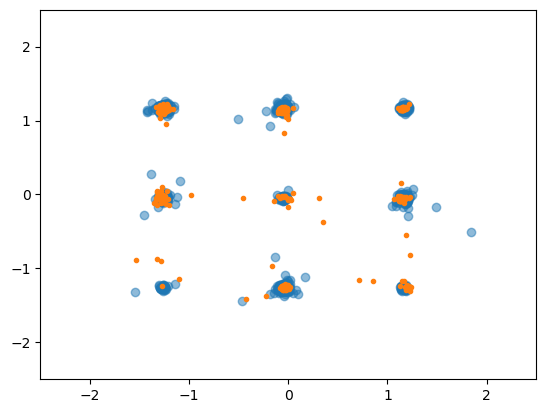

In [136]:
tmp.animation()

In [166]:
gen_model = ddim_get_perturbation_history(p, num_samples = 24, eps=5e-3)

perturbating with eps=0.0
perturbating with eps=0.005
perturbating with eps=0.01
perturbating with eps=0.015
perturbating with eps=0.02
perturbating with eps=0.025
perturbating with eps=0.03
perturbating with eps=0.035
perturbating with eps=0.04
perturbating with eps=0.045
perturbating with eps=0.05
perturbating with eps=0.055
perturbating with eps=0.06
perturbating with eps=0.065
perturbating with eps=0.07
perturbating with eps=0.075
perturbating with eps=0.08
perturbating with eps=0.085
perturbating with eps=0.09
perturbating with eps=0.095
perturbating with eps=0.1
perturbating with eps=0.105
perturbating with eps=0.11
perturbating with eps=0.115


'./animation/undefined_distribution_2.0_60_4_64.mp4'

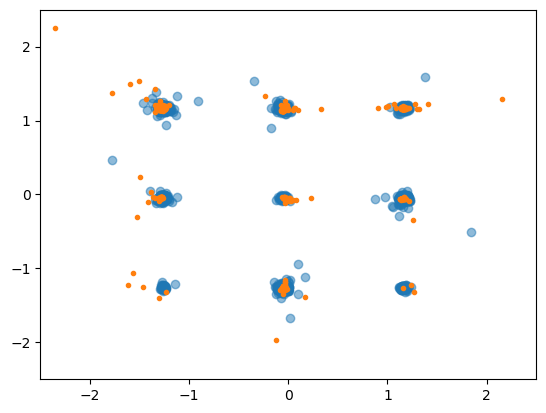

In [167]:
gen_model.animation()

## legacy

In [238]:
importlib.reload(Data)
importlib.reload(Model)
importlib.reload(Distrib)
importlib.reload(Algo)
importlib.reload(Gen)
importlib.reload(Manager)
importlib.reload(Exp)
importlib.reload(utils)
importlib.reload(Train)
importlib.reload(Logger)
importlib.reload(unet)
importlib.reload(Diffusion)
importlib.reload(Eval)

<module 'LevyDiffusion.Eval' from '/Users/darsh/inria/levy_diffusion/LevyDiffusion/LevyDiffusion/Eval.py'>

In [239]:
exp.manager.diffusion = Exp.init_diffusion_by_parameter(p)

In [240]:
exp_leg.manager.diffusion = Exp.init_legacy_diffusion_by_parameter(p)

In [241]:
gen_model = Gen.GenerationManager(exp_leg.model, 
                                  exp.manager.diffusion, 
                                  exp_leg.data)
gen_model_leg = Gen.GenerationManager(exp_leg.model, 
                                  exp_leg.manager.diffusion, 
                                  exp_leg.data)

In [242]:
same_xt = Distrib.gen_sas(exp.manager.diffusion.alpha, 
                    size = (1000, 2), 
                    device = exp.manager.diffusion.device, 
                    isotropic = True)

In [243]:
gen_model_leg.generate(1, eta=0., use_samples = same_xt, print_progression = False)

In [244]:
gen_model.generate(1, eta = 0., use_samples = same_xt, print_progression = False)

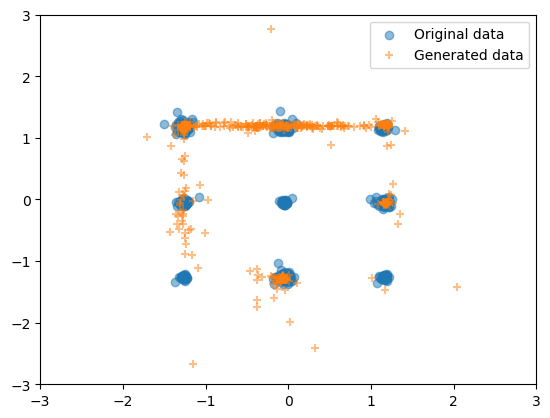

In [245]:
fig = gen_model.get_plot(xlim = (-3, 3), ylim = (-3, 3))
display(fig)

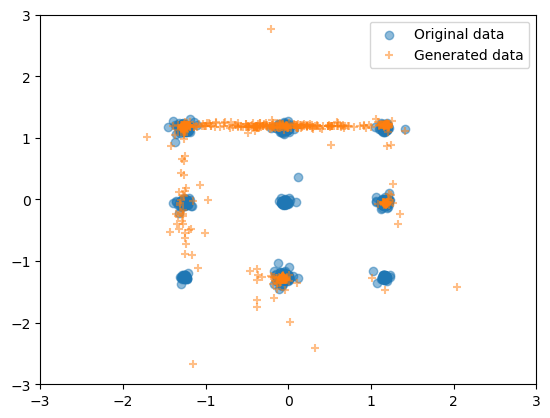

In [246]:
fig = gen_model_leg.get_plot(xlim = (-3, 3), ylim = (-3, 3))
display(fig)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 59/60 [00:02<00:00, 25.50it/s]


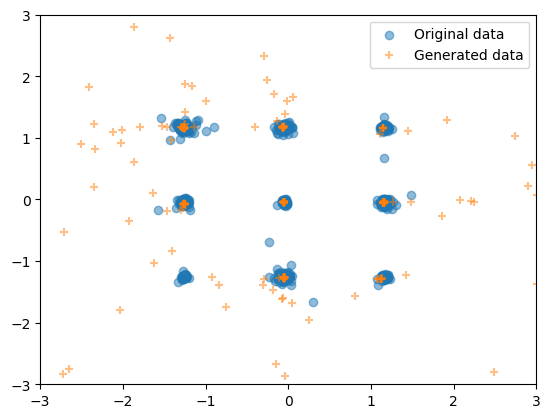

In [21]:
gen_model = Gen.GenerationManager(exp.model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.generate(2000, eta=1., print_progression = True)
fig = gen_model.get_plot(xlim = (-3, 3), ylim = (-3, 3))
display(fig)

## normal generation

In [77]:
p['LIM'] = True

In [78]:
exp = Exp.Experiment(p, 'models/test')
exp.prepare(logger = None, legacy = True)# Logger.NeptuneLogger())

In [76]:
importlib.reload(Data)
importlib.reload(Model)
importlib.reload(Distrib)
importlib.reload(Algo)
importlib.reload(Gen)
importlib.reload(Manager)
importlib.reload(Exp)
importlib.reload(utils)
importlib.reload(Train)
importlib.reload(Logger)
importlib.reload(unet)
importlib.reload(Diffusion)
importlib.reload(Eval)
importlib.reload(LIM_sampler)
importlib.reload(LIM_sde)

<module 'LevyDiffusion.LIM.functions.sde' from '/Users/darsh/inria/levy_diffusion/LevyDiffusion/LevyDiffusion/LIM/functions/sde.py'>

In [36]:
tmp_model = exp.model

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 49/50 [00:00<00:00, 232.35it/s]


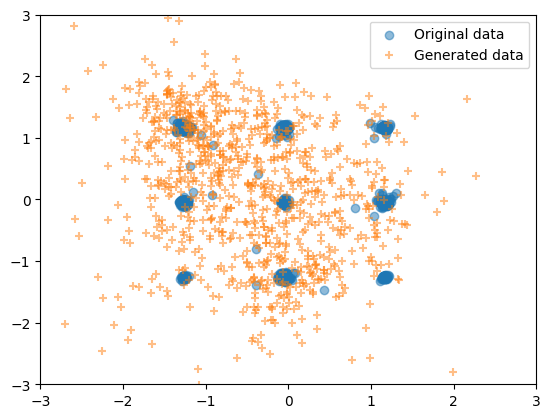

In [37]:
gen_model = Gen.GenerationManager(tmp_model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.generate(1000, eta=1., ddim = False, print_progression = True, get_sample_history=False)
lims = 3
fig = gen_model.get_plot(xlim = (-lims, lims), ylim = (-lims, lims))
display(fig)

100%|███████████████████████████████████████████| 60/60 [00:00<00:00, 98.85it/s]


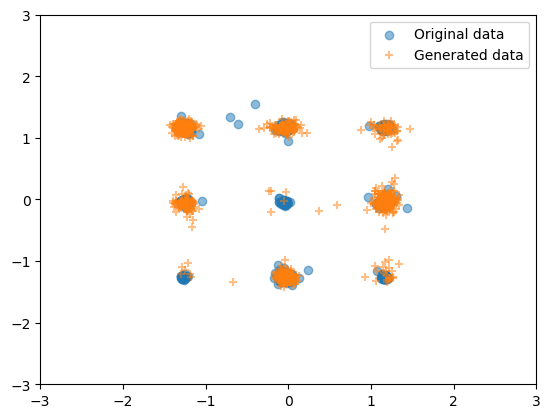

In [72]:
gen_model = Gen.GenerationManager(tmp_model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.generate(1000, eta=1., ddim = False, print_progression = True, get_sample_history=False)
lims = 3
fig = gen_model.get_plot(xlim = (-lims, lims), ylim = (-lims, lims))
display(fig)

 98%|█████████████████████████████████████████▎| 59/60 [00:00<00:00, 106.71it/s]


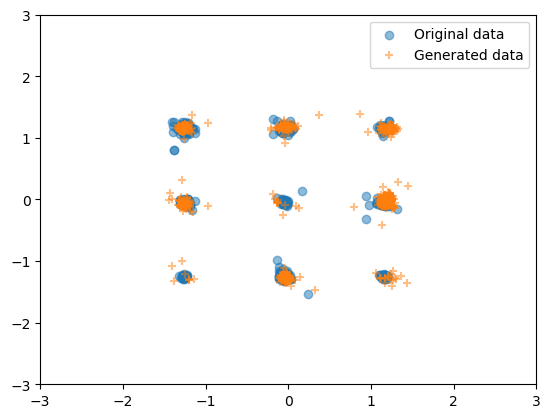

In [75]:
gen_model = Gen.GenerationManager(tmp_model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.generate(1000, eta=1., ddim = False, print_progression = True, get_sample_history=False)
lims = 3
fig = gen_model.get_plot(xlim = (-lims, lims), ylim = (-lims, lims))
display(fig)

'./animation/sas_grid_ddim_new.mp4'

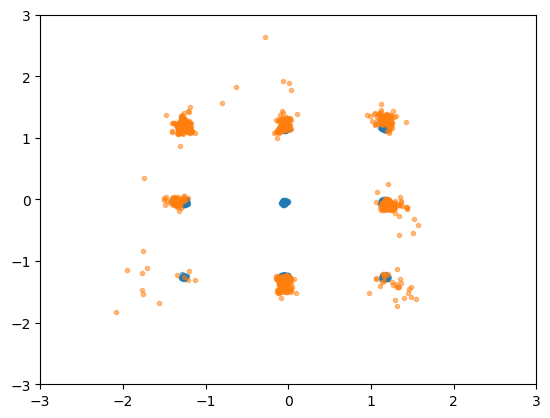

In [43]:
lims = 3
gen_model.animation(generated_data_name = 'sas_grid_ddim_new', xlim = (-lims, lims), ylim = (-lims, lims))

In [155]:
def tmp(t = 99):
    x_start = torch.tensor([[[0.]]]).repeat(1000, 1, 2).to(device)
    g, bg, t, a_t_1, a_t_prime, a_t = \
            exp.manager.diffusion._get_constants_to_incoming_batch_dims(x_start, t)
    eps = Distrib.gen_sas(1.8, 
                    size = x_start.shape,
                    a = a_t,
                    device = exp.manager.diffusion.device, 
                    isotropic = exp.manager.diffusion.isotropic)
    # compute resulting noised input
    x_t, eps = exp.manager.diffusion.q_sample(x_start, t, eps=eps)
    return exp.model(x_t, t), eps

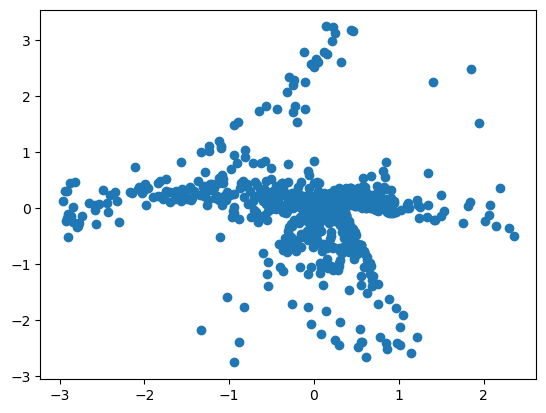

In [ ]:
to_display = x_t
t = 10
exp.model.eval()
with torch.inference_mode():
    x_t, eps = tmp(t)
    x_t, eps = x_t.squeeze(1).cpu(), eps.squeeze(1).cpu()
to_display = x_t
plt.scatter(to_display[:, 0], to_display[:, 1])
plt.show()

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 59/60 [00:01<00:00, 40.36it/s]


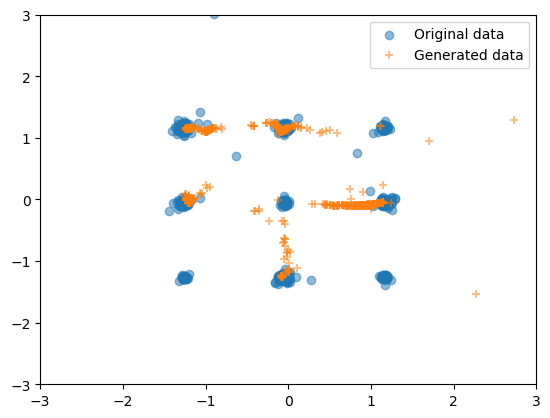

In [242]:
gen_model = Gen.GenerationManager(exp.model, 
                                  exp.manager.diffusion, 
                                  exp.data)
gen_model.generate(2000, eta=0., print_progression = True)
fig = gen_model.get_plot(xlim = (-3, 3), ylim = (-3, 3))
display(fig)

# Junk

with 1.95 ok

In [101]:
import configparser
def load_param_from_ini(path):
    config = configparser.ConfigParser()
    config.read(path)
    p = config['default']
    p = dict(p)
    for key, item in p.items():
        p[key] = eval(item)
    return p

In [102]:
p = load_param_from_ini('config.ini')

In [103]:
p['device'] = 'mps'

In [ ]:
model, data, manager = exp.load_experiment_from_param(p, './models/experiments', training_epoch = 0, use_neptune=False)